In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
K_real.shape

(2016, 75)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

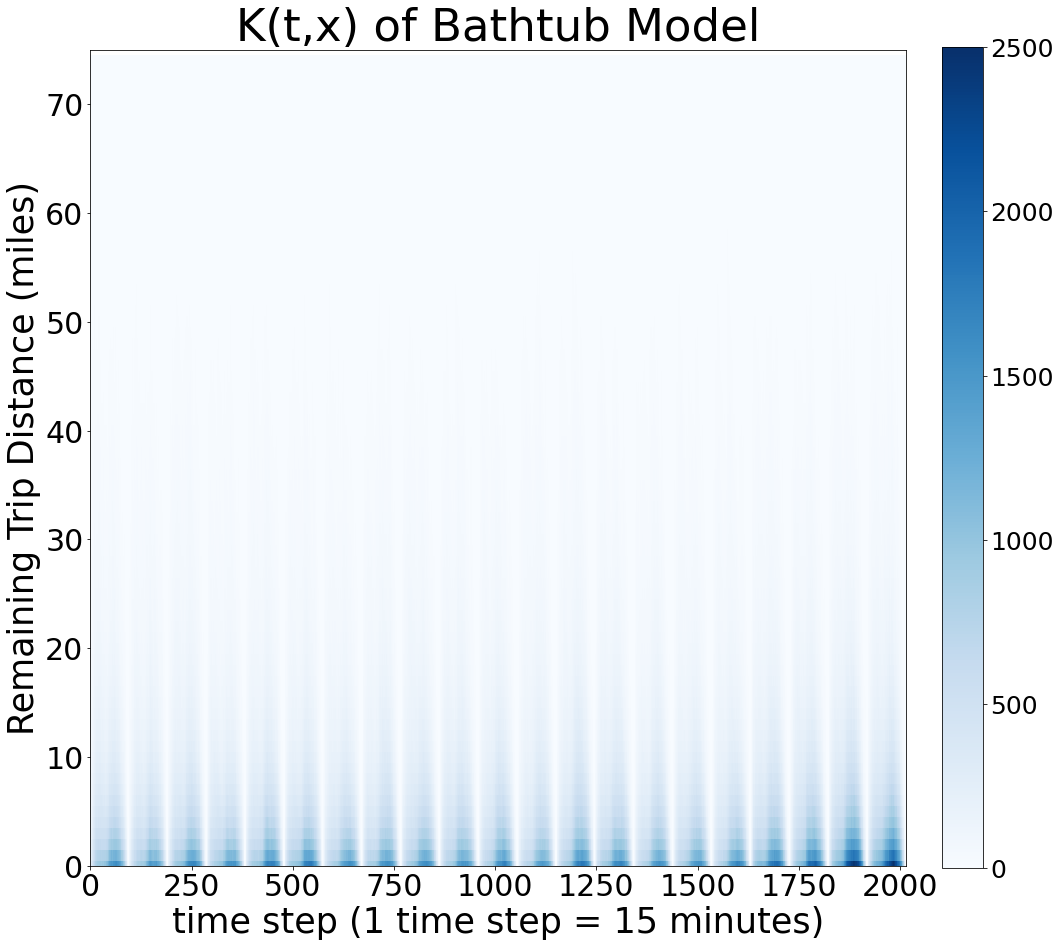

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  151200
N_u =  30240
N_f =  60480


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T.flatten()[:,None],T.T.flatten()[:,None]))
    all_u_train = usol.flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(30240, 2)

In [12]:
X_u_test.shape

(120960, 2)

In [13]:
X_u_train

array([[0.74324324, 0.39702233],
       [0.        , 0.69181141],
       [0.2027027 , 0.61687345],
       ...,
       [0.62162162, 0.55781638],
       [0.82432432, 0.82183623],
       [0.12162162, 0.13052109]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0038689535881421353 0.0058431996686702965 0.0018947075076139741 0.8164819094319086
0.0032984953131884771 0.0056384276406791041 0.00095856298569784988 0.8017004167162743
0.0027349413790150557 0.0052254623993353583 0.00024442035869475269 0.770987888817193
0.0027065304527741241 0.0051535830717846275 0.00025947783376362079 0.7656084042588547
0.0025991087942793924 0.004869255362137127 0.00032896222642165744 0.7440254113308138
0.0025862292083238627 0.0048608197389773729 0.00031163867767035217 0.7434184285785427
0.0025792550310106874 0.0048581900064583964 0.00030032005556297845 0.7432529207506089
0.002570559126753952 0.0048529620995063985 0.00028815615400150526 0.7428754886303657
0.0025457943870273053 0.0048314775855684963 0.00026011118848611397 0.7412515970655256
0.0025055938458650741 0.0047805587776203595 0.00023062891410978898 0.7373096621945959
0.0024444382299535043 0.0046670075225213915 0.00022186893738561703 0.7283500447128827
0.0023989048664037546 0.00451049668965669 0.00028731304315

0.0017395492481350463 0.0029786703776895854 0.00050042811858050709 0.5811361953783648
0.0017394517005946068 0.0029842474880910253 0.0004946559130981883 0.5816946183631699
0.0017393600293795564 0.0029774943941870444 0.0005012256645720686 0.5810272758918223
0.0017392918989178961 0.0029774816074219983 0.000501102190413794 0.5810374809425498
0.0017392286341111369 0.002977894550049427 0.00050056271817284668 0.5810736212358495
0.0017391943562423727 0.0029771432343140259 0.00050124547817071981 0.5809982037146632
0.0017391417560866675 0.0029755901817584557 0.0005026933304148794 0.5808441179168069
0.0017390628228468861 0.0029745135109899628 0.00050361213470380959 0.5807383297871845
0.0017389793775397936 0.0029732148943536168 0.00050474386072597009 0.5806107144531639
0.001738918816515942 0.002971744031050735 0.00050609360198114917 0.5804627076739209
0.0017388381393630371 0.002972572043454851 0.00050510423527122311 0.5805448988887438
0.0017388161027879173 0.0029718574913717177 0.00050577471420411

0.00172771113172136 0.002951319319976266 0.00050410294346645414 0.5785483496867869
0.0017276052881512942 0.0029491688272929957 0.00050604174900959289 0.5783340836345693
0.0017275138399207254 0.0029478009633180334 0.00050722671652341715 0.5781961583031863
0.0017274796496204044 0.0029490804511892203 0.00050587884805158845 0.5783238458942306
0.00172741184225547 0.0029459215728298558 0.0005089021116810844 0.5780041710984707
0.0017273706201901468 0.002949103586639688 0.00050563765374060578 0.5783200227582481
0.001727312798056771 0.0029477548409744324 0.00050687075513910953 0.578186375879063
0.001727239990876794 0.002947980786631024 0.00050649919512256425 0.5782079274645275
0.0017271924258369141 0.0029479736185556811 0.000506411233118147 0.5782070598319743
0.0017271788949142206 0.0029482791036565411 0.00050607868617190042 0.5782394205109226
0.0017271707584597289 0.0029477465741503013 0.00050659494276915655 0.5781884765022466
0.0017271620396474422 0.0029478062412143665 0.000506517838080518 0.

0.0017211655602026366 0.0029401024773469931 0.00050222864305828042 0.5775551327051704
0.001721154218702054 0.0029398898175651469 0.00050241861983896111 0.5775368074871765
0.0017211441754151177 0.0029403868021981548 0.00050190154863208065 0.5775869150341386
0.0017211362126349108 0.0029399639408730308 0.00050230848439679083 0.5775440672951524
0.0017211267214207015 0.0029394379632865456 0.0005028154795548574 0.5774902136381389
0.0017211162278615638 0.0029389716824995524 0.00050326077322357529 0.5774429807011314
0.0017210984195656972 0.0029386945772553086 0.00050350226187608588 0.5774135192723876
0.001721087861765686 0.0029387623205805453 0.00050341340295082665 0.5774212183028135
0.0017210777686114652 0.0029397654530215977 0.00050239008420133277 0.5775199441417457
0.0017210685964323441 0.0029403040218675246 0.00050183317099716383 0.577575068083682
0.0017210638064126529 0.0029406458698882608 0.0005014817429370448 0.5776091408767071
0.0017210561129798693 0.0029409591806808626 0.0005011530452

0.0017179445081909296 0.0029316985248673353 0.00050419049151452391 0.5766063191178831
0.0017179309699249096 0.0029322410402299035 0.00050362089961991565 0.5766556242286083
0.0017179199423669226 0.0029319735334836245 0.00050386635125022081 0.576624589401892
0.0017179024171940453 0.0029314759843121221 0.00050432885007596834 0.5765720633293645
0.0017178635451497557 0.0029310819671769322 0.00050464512312257894 0.576534951145795
0.0017178447920128527 0.0029313609989858069 0.00050432858503989854 0.5765628940410659
0.0017178179768561313 0.0029321495040308394 0.0005034864496814231 0.576649123301376
0.0017177763638780426 0.0029347229688210714 0.00050082975893501352 0.5769185944635649
0.0017177606434591358 0.0029316663090728869 0.00050385497784538483 0.5766141416920011
0.0017177529484311998 0.0029325624693212968 0.00050294342754110283 0.576703916675143
0.0017177498230992873 0.0029330900801330779 0.00050240956606549645 0.5767591260997602
0.0017177481422689447 0.002933481444631284 0.00050201483990

0.0017167713302190693 0.0029322516571091153 0.00050129100332902353 0.5766695781112963
0.0017167591242043193 0.0029327147393839173 0.00050080350902472143 0.5767124329592773
0.0017167439894871638 0.0029332563717794943 0.00050023160719483322 0.57676354111046
0.0017167265147349966 0.0029331978213651029 0.00050025520810489032 0.5767577666934401
0.0017167184356792554 0.0029324751723224379 0.0005009616990360727 0.5766848011301203
0.0017167054530652719 0.0029331279735147335 0.00050028293261581054 0.5767462325436833
0.0017166898894229871 0.0029336933046916849 0.00049968647415428934 0.5768027972148465
0.0017166750559243257 0.0029321246146760422 0.00050122549717260918 0.5766453722104521
0.0017166659105851251 0.0029335735365869468 0.00049975828458330332 0.5767881871088522
0.0017166521414303641 0.0029333285442623685 0.00049997573859835961 0.5767642769652213
0.0017166272319425909 0.0029323017708865109 0.00050095269299867075 0.5766567016609605
0.0017166114182886364 0.0029312446878503214 0.00050197814

0.0017144945137129131 0.0029265639568377189 0.00050242507058810722 0.5760311444286776
0.0017144920658875122 0.0029263284417360884 0.000502655690038936 0.5760084687653401
0.0017144886077107725 0.0029254836703019489 0.00050349354511959609 0.5759249586234777
0.0017144836736902626 0.0029268576406707492 0.00050210970670977592 0.5760636164083252
0.001714480903114345 0.0029265274845955477 0.0005024343216331426 0.5760313679775124
0.001714476555093299 0.0029263499539204842 0.00050260315626611388 0.5760133175468732
0.0017144704694206907 0.0029270268048406751 0.00050191413400070626 0.5760775085732609
0.001714467020623923 0.00292646624025434 0.00050246780099350615 0.5760239674989492
0.0017144647506808471 0.0029259664622583387 0.00050296303910335536 0.5759741471785088
0.0017144619125791236 0.00292566353177119 0.00050326029338705744 0.5759436220922766
0.0017144590824480735 0.00292570286195714 0.00050321530293900732 0.5759434156945461
0.0017144558076325491 0.0029258462175429938 0.00050306539772210462

0.001714062843669595 0.0029257647259488405 0.00050236096139034969 0.5759862125578484
0.0017140609852969637 0.0029253605806059844 0.0005027613899879431 0.5759502114680924
0.0017140566519577192 0.0029255662390496426 0.00050254706486579568 0.5759705320173966
0.0017140555929341659 0.002926084156238456 0.00050202702962987575 0.5760240154645916
0.0017140528586389665 0.0029257559864262184 0.00050234973085171446 0.5759911991654215
0.0017140517731575209 0.0029252369618343191 0.00050286658448072275 0.5759405598614901
0.0017140506169068567 0.0029252946553574482 0.00050280657845626537 0.5759443426063832
0.0017140493614912417 0.0029255525582775324 0.00050254616470495094 0.575973110314107
0.0017140482067323813 0.0029255127207798411 0.00050258369268492138 0.5759709099085677
0.00171404717828548 0.0029256002196736213 0.00050249413689733866 0.5759786335097158
0.0017140463670919774 0.0029262790883851273 0.00050181364579882733 0.5760440627603364
0.0017140458251019954 0.0029258283573239978 0.00050226329287

0.0017138939809869232 0.0029234518752512908 0.00050433608672255555 0.5757508243447513
0.0017138902902457806 0.00292274017082562 0.00050504040966594082 0.575680835667089
0.001713885417745207 0.0029224931524539726 0.00050527768303644137 0.5756565007757941
0.0017138811848918809 0.0029226027664475745 0.000505159603336187 0.5756684248133153
0.0017138746099179378 0.002923283193903461 0.00050446602593241438 0.5757351382778446
0.0017138675380958333 0.0029240080621239567 0.00050372701406770993 0.5758049813525383
0.0017138642463308026 0.0029249859635822866 0.00050274252907931869 0.5759017606699093
0.0017138605817440392 0.0029248441293210632 0.00050287703416701524 0.5758851162063926
0.0017138546327510047 0.0029253463685415303 0.000502362896960479 0.5759392057723426
0.0017138533109871195 0.0029252077829576362 0.00050249883901660271 0.5759268113133332
0.0017138482914209013 0.0029252248739900619 0.00050247170885174065 0.5759337830990393
0.0017138457504494282 0.0029247821686493162 0.00050290933224954

0.0017134647465128069 0.0029231362664827953 0.00050379322654281857 0.5757409175220091
0.0017134642216857093 0.0029228984535631247 0.000504029989808294 0.5757151294487383
0.0017134551790517192 0.0029232592067498508 0.00050365115135358747 0.5757503099308304
0.0017134512566921356 0.0029229296652650318 0.00050397284811923933 0.5757190366127168
0.0017134464127620134 0.0029230779994017281 0.00050381482612229882 0.5757361949208096
0.0017134381100112339 0.00292273466396588 0.000504141556056588 0.5757033134964463
0.0017134278089266245 0.0029217152202847636 0.00050514039756848557 0.5756066726163089
0.0017134222533641494 0.0029216216938095503 0.00050522281291874832 0.5756004608906692
0.0017134153829641927 0.0029214106398957897 0.00050542012603259584 0.5755798206342619
0.001713411624608028 0.0029213014710055166 0.00050552177821053951 0.5755680246933653
0.0017134045466662539 0.0029222107397589734 0.00050459835357353447 0.5756595619185337
0.0017133909569457004 0.0029231158456110816 0.000503666068280

0.0017117074371638254 0.0029184586729633913 0.00050495620136425967 0.5752818927890069
0.0017116954112733269 0.0029202977118182 0.00050309311072845378 0.5754510208730496
0.0017116690705669668 0.00291936405274028 0.00050397408839365386 0.5753593431220202
0.0017116551438827593 0.0029185857058579914 0.00050472458190752728 0.5752849041667458
0.0017116499535113261 0.0029188828107684123 0.00050441709625423977 0.5753148599399668
0.0017116344290850117 0.0029189850000259578 0.00050428385814406558 0.5753217799124888
0.0017116303840595559 0.0029195122834042245 0.00050374848471488741 0.5753741923279194
0.0017116221048509162 0.0029193661566749439 0.00050387805302688857 0.5753594862390881
0.0017116201761725929 0.0029179980582971759 0.00050524229404800983 0.5752184572821858
0.0017116131390536259 0.0029189177399886407 0.00050430853811861106 0.5753137382852905
0.0017116090916843216 0.0029193425520142925 0.00050387563135435084 0.575354924506
0.0017116011362382625 0.0029195810277495024 0.00050362124472702

0.0017109979910961287 0.002921416864192756 0.00050057911799950125 0.5755860367775409
0.0017109898483785675 0.0029213106749641639 0.00050066902179297088 0.5755748753803329
0.0017109840874410314 0.0029197563456742682 0.00050221182920779446 0.5754195503400961
0.0017109728906052233 0.0029195362777621496 0.00050240950344829715 0.5753976872626335
0.0017109656991541882 0.0029197390481450992 0.00050219235016327711 0.5754200962102911
0.0017109519790005222 0.0029199355492276779 0.00050196840877336638 0.5754453498857882
0.0017109344521655146 0.0029189967183567804 0.00050287218597424893 0.5753599894023492
0.0017109260730386964 0.0029197968172003518 0.00050205532887704089 0.5754390233123295
0.0017109182998630292 0.0029195644665975032 0.00050227213312855539 0.5754169538979375
0.0017109050765591743 0.0029197182440785512 0.00050209190903979751 0.5754321481581895
0.0017108976122696576 0.0029189987916007766 0.00050279643293853855 0.5753575828120187
0.0017108907425754344 0.0029184096518258757 0.000503371

0.0017101851686056446 0.0029214473393073216 0.00049892299790396742 0.5755724854049148
0.0017101838676577877 0.002921183788084758 0.00049918394723081738 0.5755451292701366
0.0017101831380247031 0.0029208609469705826 0.00049950532907882346 0.5755126360509907
0.0017101823794568353 0.0029208317995211217 0.00049953295939254882 0.5755100732119166
0.0017101797162867986 0.0029208208918144697 0.00049953854075912726 0.5755092816917908
0.0017101763444946011 0.0029208348950304384 0.000499517793958764 0.575510759883856
0.0017101716461468783 0.0029208107276899151 0.00049953256460384167 0.5755086272846571
0.0017101680138488205 0.0029209190320858319 0.000499416995611809 0.5755179726002486
0.0017101617471945308 0.0029206232995452205 0.00049970019484384121 0.5754901403241417
0.0017101556808862065 0.0029204506162505929 0.00049986074552181993 0.5754738904785034
0.0017101509191098608 0.0029204586738504202 0.0004998431643693014 0.5754763907696306
0.0017101483881179619 0.0029207550804649512 0.000499541695770

0.0017097500649400964 0.0029201804663090752 0.00049931966357111745 0.5754406277741355
0.0017097487134566055 0.0029203406812216681 0.00049915674569154318 0.5754552399719831
0.0017097472939761403 0.0029203615777756184 0.00049913301017666216 0.575458870526318
0.0017097460455532411 0.0029206531450810696 0.00049883894602541256 0.5754880143302101
0.0017097446095714164 0.0029206055607225523 0.00049888365842028052 0.5754844733253733
0.0017097430139370426 0.0029206180343131229 0.00049886799356096241 0.5754855397840424
0.0017097416286804283 0.0029205291213429394 0.00049895413601791722 0.5754766775349622
0.0017097392382099509 0.0029204976626582479 0.00049898081376165409 0.5754711126903649
0.0017097360071384924 0.0029202450371148768 0.00049922697716210814 0.5754456381980073
0.0017097292270792477 0.0029201650269343239 0.00049929342722417145 0.5754354513398032
0.0017097241937025069 0.00291949188414768 0.00049995650325733367 0.5753689447974191
0.0017097171130652797 0.0029200898555703826 0.00049934437

0.0017094604361232793 0.0029206791183708789 0.00049824175387567951 0.5754855495869037
0.0017094565508242307 0.0029201023424616397 0.00049881075918682184 0.5754262536747611
0.0017094524563521687 0.0029201735114249205 0.000498731401279417 0.5754320542866644
0.0017094494676966373 0.0029205416473960604 0.00049835728799721435 0.5754667714775568
0.0017094464209777577 0.0029202199890849081 0.00049867285287060728 0.5754366214826253
0.0017094433275176375 0.002920314308643865 0.00049857234639141 0.5754465650225888
0.0017094406746824315 0.0029202574504595788 0.0004986238989052841 0.5754402634893773
0.0017094391880494947 0.0029205330212932574 0.00049834535480573208 0.575464830159309
0.0017094374021791735 0.0029206889145123151 0.00049818588984603188 0.5754773475143287
0.0017094361363149935 0.002920631143052097 0.00049824112957789015 0.5754734996686186
0.0017094351167594086 0.002920362091713554 0.00049850814180526343 0.5754490641817651
0.0017094344738146 0.0029207059187202691 0.00049816302890893106 

0.001709315804571667 0.0029192781795187904 0.00049935342962454364 0.5753535991933891
0.0017093152260959494 0.0029193248628999694 0.0004993055892919294 0.5753565117261078
0.0017093141027454783 0.0029194229707820217 0.00049920523470893519 0.5753652077247295
0.0017093128962986312 0.0029193809366856792 0.00049924485591158318 0.575360695878036
0.0017093119408691385 0.0029198605439155786 0.00049876333782269825 0.5754061810304932
0.0017093107951493324 0.00291940185879821 0.0004992197315004549 0.5753628069313933
0.0017093104118859476 0.0029192547350591768 0.00049936608871271827 0.5753489568791681
0.0017093093935136132 0.0029193752091830052 0.000499243577844221 0.5753603532755022
0.001709309052025675 0.0029193695193939647 0.00049924858465738521 0.5753610003748062
0.001709308753665741 0.0029193092552979253 0.00049930825203355674 0.5753550178899182
0.0017093083638693187 0.0029192683826082615 0.00049934834513037582 0.5753511579049432
0.0017093081824814656 0.0029192487066159217 0.000499367658347009

0.0017091725612205747 0.0029200901302032347 0.00049825499223791461 0.575424336957628
0.001709169773064794 0.00292029412933544 0.00049804541679414815 0.575444337669647
0.0017091682364721015 0.002920328273927904 0.00049800819901629875 0.575450298301409
0.0017091651786199035 0.0029204085782340776 0.0004979217790057293 0.5754582381616149
0.0017091632510062057 0.0029199417903823959 0.00049838471163001538 0.5754123685227615
0.0017091614168134972 0.0029198072289424344 0.00049851560468455985 0.5753998039069784
0.0017091597188829198 0.0029204785986816782 0.00049784083908416125 0.575464126337525
0.0017091586674601816 0.002919796014957302 0.00049852131996306129 0.5753952611721556
0.0017091584293039207 0.0029200987762515672 0.00049821808235627429 0.5754283338223691
0.0017091573675770992 0.0029203181550519026 0.00049799658010229574 0.5754484242992328
0.001709156811332294 0.0029199853258461972 0.00049832829681839075 0.5754141999482784
0.0017091562415596196 0.0029199341298744427 0.0004983783532447964

0.0017090307347338576 0.0029187155675057591 0.00049934590196195608 0.5753070714382521
0.0017090300942672906 0.0029187332096587 0.00049932697887588131 0.5753086723525853
0.0017090293987206027 0.0029184754857668441 0.0004995833116743614 0.5752829227529392
0.0017090283814760808 0.0029186489751774568 0.00049940778777470452 0.5752995881859614
0.0017090271086138437 0.0029185730296974019 0.00049948118753028532 0.5752912087763049
0.0017090256030321113 0.0029189906085598403 0.0004990605975043823 0.5753328061616724
0.0017090244497606707 0.00291868951463121 0.00049935938489013149 0.575303306596451
0.0017090238876449131 0.0029183644101729608 0.00049968336511686546 0.5752732925848476
0.0017090229728607598 0.0029188325637733636 0.000499213381948156 0.5753208758944951
0.0017090218281634289 0.0029188290515040106 0.00049921460482284729 0.5753188530271314
0.0017090209263959961 0.0029189187209757842 0.00049912313181620777 0.5753294426429124
0.0017090196630170514 0.0029187831031614229 0.000499256222872679

0.0017088373668687684 0.0029189902166962788 0.000498684517041258 0.5753320487263116
0.0017088361270398607 0.0029186473587789149 0.0004990248953008063 0.5752977118462911
0.0017088350367241176 0.0029186535520849045 0.00049901652136333057 0.5752975384125746
0.0017088342779099774 0.002918728321083044 0.00049894023473691081 0.5753047141055859
0.0017088326939481715 0.0029188804565054975 0.00049878493139084558 0.5753203555634057
0.0017088321463862794 0.0029187496865126614 0.00049891460625989747 0.575307230523132
0.0017088303255211631 0.0029189147467291532 0.000498745904313173 0.5753251936729933
0.0017088292039543647 0.0029188564931878019 0.00049880191472092769 0.5753210752844552
0.0017088276454168307 0.0029189003337934745 0.00049875495704018659 0.5753262247470036
0.0017088258337079911 0.0029178677446524172 0.00049978392276356506 0.5752262086959952
0.0017088245979035319 0.0029183962256535976 0.00049925297015346629 0.5752782093818023
0.0017088236433226243 0.0029186158442945868 0.000499031442350

0.0017085653688239891 0.0029189575791821751 0.00049817315846580328 0.575330538069897
0.0017085573570391269 0.002918636127565215 0.000498478586513039 0.5752969178976342
0.0017085506371033038 0.0029199405059708657 0.00049716076823574169 0.575421890119755
0.0017085451363995717 0.0029197443524025353 0.00049734592039660816 0.5754014307803563
0.0017085410383483476 0.0029200425219912175 0.00049703955470547774 0.5754357247896258
0.0017085334655656543 0.0029197724773107406 0.00049729445382056816 0.575405761779956
0.0017085284602742163 0.0029193223797338787 0.00049773454081455384 0.5753599372841566
0.0017085216921966496 0.0029195811117302141 0.00049746227266308477 0.5753889230671894
0.0017085097338951022 0.0029200300561188649 0.00049698941167133958 0.5754313436640319
0.0017085044277050242 0.0029184924579902607 0.00049851639741978768 0.5752667024189368
0.0017084950427449187 0.0029189579836262527 0.00049803210186358487 0.5753156597711873
0.0017084928891722246 0.0029196921637444154 0.00049729361460

0.0017081554386345285 0.0029187247336374209 0.000497586143631636 0.5753095555435686
0.0017081541736054843 0.0029189406012181578 0.00049736774599281068 0.5753302516506188
0.0017081527953874327 0.0029188741750703806 0.00049743141570448473 0.5753238834038847
0.001708151586364068 0.0029190057026612761 0.00049729747006685985 0.5753372937757852
0.0017081503025766027 0.0029188429886182581 0.00049745761653494731 0.5753213899052442
0.0017081488790035744 0.0029185602101937484 0.00049773754781340027 0.5752953412184301
0.0017081462150577266 0.00291853431716298 0.00049775811295247317 0.5752929017283707
0.0017081405254505205 0.0029185807985838553 0.00049770025231718571 0.5752954786651163
0.0017081366504988983 0.0029186264270935109 0.00049764687390428566 0.5752970564501394
0.0017081314473488571 0.0029186007294825919 0.000497662165215122 0.5752912780968316
0.0017081242729116652 0.0029182267455485434 0.00049802180027478694 0.5752526034832628
0.0017081194089949075 0.002918824029567885 0.0004974147884219

0.0017071965520206709 0.0029165077646497737 0.00049788533939156823 0.5750888445026296
0.00170718908429952 0.0029167184488845693 0.00049765971971447065 0.5751076836199511
0.0017071839071704257 0.002916876413146619 0.00049749140119423254 0.5751251252735445
0.0017071812561335472 0.0029172827426776908 0.00049707976958940369 0.5751644649644596
0.0017071778534925646 0.0029171967192155612 0.000497158987769568 0.5751540566861623
0.0017071730018096323 0.0029164425108341519 0.00049790349278511258 0.5750818632730746
0.0017071657695193654 0.0029163965739837038 0.00049793496505502678 0.5750785485824151
0.0017071583840409207 0.0029161444703409306 0.00049817229774091088 0.5750582267826372
0.0017071535105467044 0.0029164755449204217 0.00049783147617298712 0.5750907318181814
0.0017071466086474238 0.0029166744282705663 0.00049761878902428126 0.5751066596030707
0.0017071420293545054 0.0029162444990992928 0.00049803955960971776 0.575066158478025
0.0017071369546034156 0.0029168490643242096 0.00049742484488

0.0017054252893461573 0.0029152886627436658 0.000495561915948649 0.5749798884960908
0.0017053611270488192 0.0029155298111024934 0.000495192442995145 0.5750004982482958
0.0017052247564891868 0.0029144692613164713 0.00049598025166190207 0.5748895095202325
0.0017050703291639493 0.0029152503507761302 0.00049489030755176845 0.5749556905360383
0.0017049487468777037 0.0029136113755931013 0.00049628611816230619 0.574783416427136
0.001704887114675173 0.0029121608781737841 0.00049761335117656162 0.5746505528187865
0.0017047846602887503 0.0029163148065195258 0.000493254514057975 0.5750600180457343
0.0017047673986809243 0.00291824343861903 0.00049129135874281837 0.5752134583418201
0.001704612361938035 0.0029172234254231447 0.00049200129845292529 0.5751218606103983
0.0017045146177489109 0.0029168200973368232 0.00049220913816099845 0.5750902741735551
0.0017044389752341822 0.0029113751115683565 0.00049750283890000787 0.5745488288143369
0.0017043973651858133 0.0029109534448123024 0.0004978412855593240

0.0017028609567574121 0.0029115731726177363 0.00049414874089708785 0.5745451560581604
0.0017028552157815368 0.0029120113938926515 0.00049369903767042234 0.5745904782867163
0.001702848655059876 0.0029118369016267191 0.00049386040849303274 0.5745730410917881
0.0017028418963434648 0.0029119040509593894 0.00049377974172754046 0.5745735399718085
0.0017028381953693036 0.0029116505077780241 0.00049402588296058284 0.5745454091156068
0.0017028357263595237 0.0029118007628602016 0.00049387068985884582 0.574556999274477
0.0017028327665797758 0.0029114744093116664 0.00049419112384788513 0.5745239128876707
0.001702827600470302 0.0029113816979475038 0.00049427350299310034 0.5745140461873942
0.0017028192117357975 0.0029108626128011685 0.00049477581067042644 0.5744633300667168
0.0017028061472623129 0.0029106821006919963 0.0004949301938326294 0.574445744984469
0.0017027872451864856 0.0029105856361752677 0.0004949888541977037 0.5744332539145514
0.0017027746478461908 0.00291061949748021 0.0004949297982121

0.0017021985084659302 0.0029117109335130612 0.000492686083418799 0.574534709683746
0.0017021966750190383 0.0029115999089332489 0.00049279344110482752 0.5745257139785543
0.0017021939084739353 0.0029117719857664629 0.00049261583118140751 0.574543760885538
0.0017021920755968074 0.0029116880455771258 0.0004926961056164889 0.5745372487960609
0.0017021900377628327 0.0029118973868560911 0.0004924826886695742 0.574558954329908
0.0017021891890889763 0.0029118451333913528 0.00049253324478659981 0.5745535835971051
0.0017021878851190776 0.0029117902391534241 0.00049258553108473112 0.5745478404072751
0.0017021849452546255 0.0029120000713289515 0.00049236981918029954 0.5745651140588476
0.0017021826427122805 0.0029119325687344292 0.000492432716690132 0.5745582415645041
0.0017021775138611286 0.0029118639047617653 0.00049249112296049211 0.5745505258096052
0.001702172529555737 0.0029117633408200167 0.0004925817182914572 0.5745419902826796
0.0017021698141387175 0.0029118744939943104 0.0004924651342831247

0.0017019346037294302 0.0029106101961623131 0.00049325901129654726 0.5744436223759245
0.0017019318538729043 0.0029108013231760412 0.00049306238456976726 0.5744615017311472
0.0017019286371928195 0.0029110947910856752 0.00049276248329996352 0.5744882200580073
0.0017019254494685338 0.0029114102262429078 0.00049244067269415962 0.5745186772301564
0.001701923121921673 0.0029114565478558117 0.00049238969598753429 0.5745233799200719
0.0017019194126426968 0.0029112960937243294 0.00049254273156106433 0.5745082993220032
0.001701915104242381 0.0029115190416687531 0.00049231116681600887 0.5745296884834413
0.0017019093571897842 0.0029111778465529536 0.00049264086782661485 0.5744990004024463
0.0017019045034400854 0.0029117375569793582 0.00049207144990081274 0.5745534764592692
0.0017018993759441239 0.0029116585224444628 0.000492140229443785 0.5745431751826092
0.0017018950680944194 0.0029117448645140718 0.000492045271674767 0.5745488300244513
0.0017018902601342303 0.0029110029406642052 0.00049277757960

0.0017015881770344084 0.0029103092554674664 0.00049286709860135031 0.5744088998539153
0.0017015843958355448 0.0029107408233702641 0.00049242796830082562 0.5744523057328601
0.0017015820258185653 0.0029102557173289506 0.00049290833430818012 0.5744034072717513
0.0017015781164072142 0.0029108518926041203 0.00049230434021030832 0.5744641399491303
0.0017015755470665618 0.0029105365681942707 0.00049261452593885307 0.574431135312614
0.0017015729363256218 0.0029104426653555203 0.00049270320729572306 0.5744218497413207
0.0017015699837020721 0.0029111013480016767 0.00049203861940246767 0.5744861072238807
0.001701567175922744 0.0029110485801408688 0.000492085771704619 0.5744813122981016
0.0017015639768419642 0.0029112982881159006 0.000491829665568028 0.5745030503670603
0.0017015612768853041 0.0029115174582218504 0.00049160509554875781 0.5745260665172234
0.0017015583414653032 0.0029112471868472756 0.00049186949608333113 0.5745012005758591
0.0017015560921372595 0.0029108602343425167 0.00049225194993

0.001701263988941935 0.0029096048710955413 0.00049292310678832865 0.5743173578778441
0.0017012621513864022 0.0029096823599546739 0.00049284194281813036 0.5743251516166977
0.0017012612810893531 0.0029096993609637758 0.00049282320121493022 0.5743264701656272
0.001701259549226646 0.0029098215151164238 0.00049269758333686812 0.5743392043250265
0.001701258250535017 0.0029096784118466282 0.00049283808922340557 0.5743245416447794
0.0017012543657067465 0.0029093474171572212 0.00049316131425627171 0.5742905673407136
0.0017012481677130729 0.0029093266616627813 0.00049316967376336455 0.5742902279489417
0.0017012398838727428 0.0029092298358231847 0.000493249931922301 0.5742799273241973
0.0017012303620681961 0.0029094748842319849 0.00049298583990440745 0.5743116592198187
0.0017012291115780709 0.0029101937008475889 0.0004922645223085526 0.5743823386721508
0.0017012271624153551 0.0029107686107461856 0.00049168571408452464 0.5744407681211057
0.0017012262735237485 0.00290965810515047 0.0004927944418970

0.0017009323813586311 0.00290977453588044 0.00049209022683682237 0.5743331688721303
0.0017009190477592147 0.0029093253231781769 0.0004925127723402527 0.5742907614820996
0.0017009129599988926 0.0029092263381987242 0.00049259958179906089 0.5742796913429485
0.0017009021480089846 0.0029101697547727103 0.000491634541245259 0.5743709966918028
0.0017008902162348495 0.002909365707566777 0.00049241472490292213 0.574287225009503
0.0017008836504660181 0.002908740375869009 0.00049302692506302719 0.5742347386172557
0.0017008737573665008 0.0029086792208066611 0.00049306829392634056 0.5742218518836582
0.001700865243501794 0.0029090999796348694 0.00049263050736871885 0.5742569977064287
0.0017008572341478097 0.0029101279384276 0.00049158652986801927 0.5743553586319412
0.0017008480539921547 0.0029087480303842295 0.00049294807760008011 0.5742192901793928
0.0017008382033989941 0.0029087474289333235 0.00049292897786466479 0.5742196893950722
0.0017008312616028109 0.0029089256276195723 0.00049273689558604957

0.0017002143347250719 0.0029085884500822841 0.00049184021936785961 0.5742534792029823
0.00170021092545793 0.0029082522348814702 0.00049216961603439 0.5742205170262652
0.0017002067870838691 0.0029079608104119461 0.00049245276375579233 0.5741915442609401
0.0017002041847351467 0.0029073705382136063 0.00049303783125668739 0.5741327955962694
0.0017002008654330824 0.0029083116800630261 0.00049209005080313875 0.5742256460040226
0.0017001985302043394 0.0029084350067241182 0.00049196205368456057 0.5742373935500253
0.0017001966226452769 0.0029082104622924049 0.00049218278299814893 0.5742140344840119
0.0017001939066231865 0.002908348547872296 0.00049203926537407709 0.57422728689534
0.0017001903907867266 0.0029085137615606441 0.00049186702001280923 0.5742411631133635
0.0017001872158205575 0.0029085324154266793 0.00049184201621443565 0.5742422964451181
0.0017001830603468823 0.0029082549566670618 0.00049211116402670264 0.5742114670937559
0.0017001784222952093 0.0029085159414137182 0.0004918409031767

0.0016993370026763333 0.0029082013751775982 0.00049047263017506831 0.5742023040714372
0.0016993265867402891 0.0029083642983066095 0.00049028887517396863 0.5742189805354124
0.0016993127916914604 0.0029088798374118665 0.00048974574597105433 0.574268242787839
0.001699302063308146 0.0029096613615482137 0.00048894276506807847 0.5743535039504565
0.0016992944691512025 0.00290988864817262 0.00048870029012978511 0.5743690897544045
0.0016992879359653392 0.00290906624213537 0.0004895096297953083 0.5742888782857287
0.0016992832632496473 0.00290933544876755 0.00048923107773174489 0.5743180122153907
0.0016992768465714284 0.0029092120370071976 0.00048934165613565906 0.5743092302294772
0.0016992686162918193 0.0029099194534293622 0.00048861777915427647 0.5743781165237895
0.001699261032869325 0.0029087359002999539 0.00048978616543869625 0.5742613363357219
0.0016992524885297722 0.0029091073885377057 0.00048939758852183882 0.5742981017611337
0.0016992443865948914 0.0029092827693630004 0.000489206003826782

0.0016985998712585053 0.0029082874587915662 0.00048891228372544427 0.5742261411975573
0.001698586312717175 0.0029078549496032034 0.00048931767583114654 0.5741782092631288
0.0016985820140347893 0.0029083508123811394 0.00048881321568843917 0.5742259904598176
0.0016985708378475649 0.0029086465773371594 0.00048849509835797035 0.5742553265769108
0.0016985649470720693 0.0029084183417130154 0.00048871155243112316 0.574231859952622
0.0016985606586799916 0.00290848596713138 0.00048863535022860313 0.5742478189499269
0.0016985513242620855 0.0029073280443198831 0.00048977460420428806 0.5741270044984922
0.0016985490942399686 0.0029076595450687145 0.00048943864341122287 0.5741574704016106
0.0016985440222497456 0.00290777492760501 0.00048931311689448141 0.5741670095881984
0.0016985390670163315 0.0029077229100225948 0.00048935522401006833 0.5741634209640588
0.00169853240132054 0.0029076270272046048 0.00048943777543647513 0.5741531179411951
0.0016985264110423615 0.0029076566031946416 0.0004893962188900

0.0016981045562349309 0.0029059674247938474 0.00049024168767601442 0.5739764404816772
0.0016980989827848751 0.0029060677312229668 0.00049013023434678359 0.5739876718595531
0.0016980923934433552 0.0029061972950637721 0.000489987491822938 0.5740017822444228
0.0016980852456896993 0.002906038021861776 0.0004901324695176227 0.5739885893319243
0.0016980845991872112 0.0029070015342204788 0.00048916766415394374 0.5740916063146092
0.0016980758768643141 0.0029064590194678303 0.00048969273426079812 0.5740358472691204
0.0016980723935566685 0.0029065364815740232 0.00048960830553931379 0.5740440091408212
0.0016980705576758125 0.0029056378986799373 0.00049050321667168763 0.5739575597609206
0.0016980654728739658 0.0029066826813519218 0.00048944826439600993 0.5740630864135631
0.0016980624377705927 0.0029069233751279813 0.00048920150041320413 0.5740867131906088
0.0016980549457218472 0.00290704500408719 0.00048906488735650478 0.5740992954865297
0.0016980501279212326 0.0029068557336768127 0.00048924452216

0.0016976203865715102 0.0029073992475411397 0.00048784152560188063 0.5741408112387634
0.0016976167524667182 0.0029073100820939351 0.00048792342283950107 0.574131638906588
0.0016976121534875547 0.0029073283085542996 0.00048789599842080975 0.5741304120584018
0.0016976059757046491 0.002906773513833851 0.00048843843757544734 0.5740745674658015
0.0016976039385383213 0.0029066478681075356 0.00048856000896910711 0.5740613416008488
0.0016976009347882083 0.0029069023182638808 0.00048829955131253586 0.5740836719750497
0.0016975975048460967 0.0029067628695676156 0.00048843214012457786 0.5740720672982477
0.0016975951471173258 0.0029069365749221439 0.00048825371931250769 0.5740919087178691
0.0016975923189160406 0.0029069546550764989 0.00048822998275558239 0.5740952205858166
0.0016975872846687265 0.0029068651471783088 0.00048830942215914415 0.5740874652543451
0.0016975811737729759 0.0029069484103021017 0.00048821393724385033 0.5740928650357117
0.001697574428495253 0.0029067771837393225 0.00048837167

0.0016970511753340509 0.0029063145117638597 0.00048778783890424219 0.5740609994636131
0.0016970457698157731 0.0029064028747411708 0.0004876886648903753 0.5740680217604515
0.001697041161427517 0.0029067368039120203 0.00048734551894301392 0.5741044261219193
0.0016970299807239494 0.0029064353277108287 0.00048762463373706996 0.5740651674972526
0.0016970200557374876 0.0029056427097270535 0.0004883974017479215 0.5739910100223099
0.0016970118976990284 0.0029050354964824522 0.00048898829891560471 0.5739316982149842
0.0016970051325591686 0.0029071560598373397 0.00048685420528099739 0.5741428988926881
0.0016969955140596861 0.0029049385052966172 0.00048905252282275494 0.5739218856471967
0.0016969881469193929 0.0029051590254482022 0.00048881726839058353 0.5739422457711775
0.0016969809454651509 0.0029057805182564158 0.00048818137267388613 0.574004487709946
0.0016969762121163258 0.0029058733144691228 0.00048807910976352871 0.5740114080058659
0.0016969719996052376 0.0029061041293908891 0.000487839869

0.0016961302152277836 0.0029036576391009423 0.00048860279135462493 0.5737946398141839
0.0016961158774384622 0.0029041371726585838 0.00048809458221834049 0.5738480432926361
0.0016961064107472545 0.0029039120878336456 0.0004883007336608635 0.5738241313986868
0.0016960958097547237 0.00290387715033805 0.00048831446917139737 0.573825015979495
0.0016960838608433575 0.002904255706849863 0.00048791201483685176 0.573863305000816
0.0016960735346933497 0.002904128251276299 0.00048801881811040023 0.573846023915878
0.0016960649042103378 0.002904846762792792 0.00048728304562788383 0.5739155774718888
0.0016960543014378595 0.0029047057737816226 0.00048740282909409639 0.5739016788714378
0.0016960454322965523 0.0029052735053486868 0.00048681735924441759 0.5739530189716595
0.0016960404826615546 0.0029040029556573247 0.00048807800966578475 0.5738267758669703
0.0016960309705290836 0.0029044366934138609 0.00048762524764430642 0.5738717850119364
0.001696027696564062 0.0029052723361305596 0.000486783056997564

0.0016947898440513719 0.0029023828575167575 0.0004871968305859864 0.5737344249792323
0.0016947792208580235 0.002903222861556256 0.00048633558015979093 0.5738187008256991
0.0016947724513900614 0.0029027392948585435 0.00048680560792157938 0.5737676958377148
0.0016947650284916758 0.0029025257732723914 0.00048700428371096 0.573745545063289
0.0016947591306975551 0.0029029082640848396 0.00048660999731027071 0.5737852489791495
0.0016947556429186396 0.0029022145208494809 0.00048729676498779839 0.5737201848507101
0.0016947481227640752 0.0029027630775019749 0.00048673316802617532 0.5737759684746578
0.0016947423859998321 0.0029030052758972739 0.00048647949610239034 0.5737997556526021
0.0016947343404180109 0.0029034388971745724 0.00048602978366144934 0.5738464147962803
0.0016947201578648432 0.002903641503471562 0.00048579881225812444 0.5738652469542258
0.0016946919609530579 0.0029033017996245615 0.00048608212228155423 0.573829657371551
0.0016946413829180725 0.0029031863685836054 0.0004860963972525

0.0016933595715723914 0.0029015672766936878 0.000485151866451095 0.5736298104109794
0.0016933545533826533 0.0029024690421992714 0.00048424006456603528 0.5737156191173772
0.0016933504897412967 0.0029024243276941047 0.00048427665178848886 0.5737088860239248
0.0016933407925314196 0.0029018467342464323 0.00048483485081640692 0.5736540664674076
0.001693331069649329 0.0029022709985615336 0.00048439114073712462 0.57369973529685
0.0016933219755059655 0.0029018919258052165 0.00048475202520671445 0.5736644426774338
0.0016933095555442534 0.0029020717209083113 0.00048454739018019566 0.5736854268213732
0.0016932932733205888 0.0029029344489546567 0.00048365209768652082 0.5737674118559793
0.0016932803475643438 0.0029032302219785082 0.00048333047315017916 0.5737968311601815
0.0016932666864399276 0.0029032728103786476 0.0004832605625012074 0.5737957422763192
0.0016932544213143351 0.0029024800353032155 0.00048402880732545471 0.5737145666149738
0.0016932366063900372 0.0029021073958426973 0.00048436581693

0.0016920183094986036 0.0029000435483901737 0.00048399307060703346 0.5734717025828213
0.001692010567667014 0.0028998149201962453 0.00048420621513778247 0.5734473221896852
0.0016920040115660658 0.0029006239719664259 0.00048338405116570585 0.5735305091450281
0.0016919993853044273 0.0029008055417563973 0.00048319322885245704 0.5735491753957512
0.0016919965870785256 0.0029006588070464604 0.00048333436711059087 0.573536104815074
0.0016919934925539897 0.0029008104228091126 0.00048317656229886696 0.5735504148768281
0.0016919924731881586 0.0029004228890155107 0.00048356205736080647 0.5735180250323013
0.001691986578496232 0.0029005261637492707 0.00048344699324319316 0.5735245392152837
0.0016919816629591242 0.0029005667184046164 0.00048339660751363172 0.5735269421529245
0.001691973172904634 0.0029005452754267791 0.00048340107038248912 0.5735214798767521
0.0016919642382392534 0.0029000807608600214 0.00048384771561848529 0.573477038711003
0.001691954825858642 0.0029000932075426834 0.00048381644417

0.001691314510568171 0.0028990947641936728 0.00048353425694266943 0.5733739364832877
0.0016913114152194292 0.0028989697728989605 0.00048365305753989793 0.5733644936035935
0.0016913083334605507 0.0028990448676391579 0.00048357179928194355 0.5733704231139136
0.0016913019506713668 0.0028990456249505209 0.0004835582763922127 0.5733686379108509
0.001691293532574723 0.0028987937751135807 0.00048379329003586533 0.573342356647136
0.0016912833460632944 0.0028989863039650533 0.0004835803881615352 0.5733573143859777
0.0016912757866257466 0.0028984935061855377 0.00048405806706595559 0.5733051124884032
0.0016912634770552787 0.0028982928740461556 0.00048423408006440178 0.5732856054696206
0.0016912473033777341 0.002898325777875182 0.00048416882888028596 0.5732863530441138
0.00169123788638279 0.0028983741064045028 0.00048410166636107734 0.5732864635188053
0.0016912295033992197 0.0028978468035688746 0.00048461220322956468 0.5732355915331074
0.001691222735840154 0.0028981661362223821 0.00048427933545792

0.001690480953025434 0.0028982349167531868 0.00048272698929768116 0.5732981676600201
0.0016904737562312686 0.0028985362906918609 0.00048241122177067656 0.5733307321002595
0.0016904630448580605 0.0028987744388470379 0.00048215165086908324 0.5733557515723864
0.0016904564732669804 0.0028987011841162223 0.00048221176241773856 0.5733512043784533
0.0016904494076644212 0.0028986518219205459 0.00048224699340829668 0.5733480272311926
0.0016904433407381838 0.0028984779935822902 0.00048240868789407729 0.5733299680996795
0.0016904389316185796 0.0028982324117740495 0.00048264545146311 0.5733025497947655
0.0016904357146539889 0.0028981225180840756 0.00048274891122390234 0.5732904113510293
0.0016904325578586535 0.002898081762749717 0.00048278335296759014 0.5732845864757493
0.0016904264130318026 0.0028979248115001024 0.00048292801456350289 0.5732671109385585
0.0016904211542195428 0.0028977529530174479 0.00048308935542163762 0.573251194412645
0.0016904099512879368 0.0028978785022751824 0.00048294140030

0.0016895273091002011 0.0028950220674483192 0.0004840325507520829 0.5729754237647546
0.0016895226842868129 0.0028954392936167872 0.00048360607495683862 0.5730163321778422
0.0016895190406132274 0.0028950981300841128 0.0004839399511423421 0.5729815415387626
0.0016895145315193305 0.0028951900906214671 0.00048383897241719391 0.5729915137682567
0.0016895004939489276 0.0028945142583001278 0.0004844867295977274 0.5729283143982312
0.0016894874031594875 0.0028946475510493296 0.00048432725526964543 0.5729445129328865
0.0016894834907943098 0.0028942626862526366 0.00048470429533598286 0.57290558223726
0.0016894685142475486 0.0028944820729190609 0.00048445495557603637 0.5729304147090158
0.0016894554608251765 0.0028950945361619434 0.00048381638548840956 0.5729895933687718
0.0016894456664960328 0.002895185963882383 0.00048370536910968262 0.5730016034170347
0.001689436207459614 0.0028951535031839894 0.00048371891173523864 0.5729951404136449
0.0016894292026464167 0.002894878303574776 0.0004839801017180

0.0016889603156535053 0.0028953549741518344 0.00048256565715517626 0.5729968945103692
0.0016889567136648474 0.0028954703281331567 0.00048244309919653829 0.5730088726451132
0.001688954790402921 0.0028948963748429667 0.0004830132059628753 0.5729522425130841
0.0016889508002551458 0.0028949290008704908 0.00048297259963980062 0.5729565950071954
0.0016889483271087928 0.0028953780723125328 0.00048251858190505277 0.5730012769068799
0.0016889450109897133 0.0028953208910158556 0.0004825691309635709 0.5729946798726062
0.0016889425026004714 0.0028952162985937785 0.00048266870660716396 0.5729844297180028
0.0016889395619585519 0.0028956211020462314 0.00048225802187087241 0.5730230204275695
0.0016889367273528076 0.0028950523580315427 0.00048282109667407242 0.5729664221268508
0.0016889341292482725 0.0028952673673255762 0.00048260089117096864 0.572986877657251
0.0016889315674322621 0.0028954053074236766 0.00048245782744084749 0.5730005416215951
0.0016889275301909812 0.0028954792668762748 0.000482375793

0.0016884564808071943 0.0028940997757798638 0.00048281318583452481 0.5728855977853538
0.0016884554159722399 0.0028942822814020811 0.00048262855054239886 0.5729038636282475
0.0016884534328342206 0.0028941892118566196 0.00048271765381182165 0.5728951519584621
0.0016884517696638093 0.0028941948648131158 0.00048270867451450294 0.5728967741037482
0.0016884499887025429 0.0028942659440539839 0.0004826340333511019 0.5729036769935607
0.0016884487403813328 0.0028943724195597651 0.00048252506120290064 0.5729143153369352
0.0016884477808419905 0.0028943604781842889 0.00048253508349969221 0.5729121109487952
0.0016884471240423778 0.0028943711726499952 0.00048252307543476038 0.5729112314831303
0.0016884465409977097 0.002894290616614433 0.00048260246538098635 0.5729027523372846
0.0016884459161281068 0.0028942349375656513 0.00048265689469056218 0.5728965282489394
0.0016884453590501364 0.0028942310090574004 0.0004826597090428723 0.5728969353585375
0.0016884437481840063 0.0028940448290976795 0.00048284266

0.0016880487738469506 0.0028948414102982589 0.00048125613739564223 0.572972897430438
0.0016880418524750529 0.0028946256766029144 0.0004814580283471916 0.5729532912899147
0.001688034305537627 0.0028947540130285112 0.00048131459804674282 0.5729668995480612
0.0016880256171645837 0.002895024712530296 0.00048102652179887148 0.5729943268195495
0.0016880155289736567 0.002895833656749025 0.00048019740119828854 0.5730742696192831
0.0016879988924407771 0.0028960418760716733 0.00047995590880988109 0.5730946094745974
0.0016879706479461497 0.0028960809217695427 0.00047986037412275673 0.5730963004251896
0.0016879418340007685 0.0028954050700877522 0.00048047859791378484 0.5730273058250942
0.0016879315218274651 0.0028949506327992391 0.00048091241085569084 0.5729864449730492
0.0016879230146912526 0.0028937706905433156 0.00048207533883918956 0.5728722274101277
0.0016879134244880713 0.0028939347790695137 0.00048189206990662876 0.572887065821286
0.0016879018531452885 0.0028949445944371271 0.00048085911185

0.0016875061398216285 0.0028938900357679317 0.00048112224387532548 0.5728795805141133
0.001687503197218759 0.0028941097431382685 0.00048089665129924958 0.5728994553961461
0.0016875012034177298 0.0028941250598325139 0.00048087734700294585 0.5729023318073285
0.0016874974318992419 0.0028941181787372422 0.00048087668506124166 0.5729026895327118
0.001687492825251912 0.0028946094421436969 0.00048037620836012714 0.5729542900960455
0.0016874891351610231 0.0028940856576814846 0.00048089261264056178 0.5729044633779612
0.0016874855974275619 0.0028944198479842519 0.00048055134687087188 0.5729396690561882
0.0016874801416128888 0.0028947867671030559 0.00048017351612272157 0.5729784062907689
0.0016874754511264447 0.0028945558902818136 0.000480395011971076 0.5729548492598676
0.0016874701710973567 0.0028946356840199661 0.0004803046581747471 0.5729641917258905
0.0016874643775956263 0.0028949174085764876 0.000480011346614765 0.5729920510197016
0.0016874552468247935 0.0028947775134648655 0.000480132980184

0.0016870882451159857 0.0028943135681107311 0.00047986292212124027 0.5729399253688989
0.0016870838281287323 0.0028949265849598825 0.000479241071297582 0.5729991795892667
0.0016870825779216885 0.0028948783540263738 0.00047928680181700314 0.5729952204270884
0.0016870765334991091 0.0028945969470658807 0.0004795561199323374 0.5729651376244739
0.0016870740391515544 0.0028945728499381583 0.00047957522836495064 0.5729628223476607
0.0016870722901431981 0.0028944803259291435 0.00047966425435725242 0.5729534242271449
0.0016870701097327144 0.002894521061469273 0.00047961915799615574 0.5729563839922489
0.0016870670490014192 0.0028944800955930396 0.0004796540024097988 0.5729543345471048
0.0016870633824558631 0.0028946444989514986 0.00047948226596022757 0.5729705853620746
0.0016870596969079212 0.0028947996497882471 0.00047931974402759536 0.572984359057583
0.0016870571096573252 0.0028946671477552231 0.00047944707155942709 0.5729698851840171
0.0016870543538099456 0.0028947093588698718 0.00047939934875

0.0016867293212266021 0.0028942252975655241 0.00047923334488767996 0.5729263922057715
0.0016867284357959943 0.0028942905541721842 0.00047916631741980431 0.572933047523693
0.001686727127682912 0.0028942755763700684 0.00047917867899575559 0.572931177752138
0.001686724933181128 0.0028940781503374877 0.00047937171602476821 0.572911417839271
0.0016867237257870587 0.0028941536138854551 0.00047929383768866224 0.5729192266033634
0.0016867212811604454 0.0028941134612927746 0.000479329101028116 0.5729140491708569
0.0016867183843234305 0.0028939072894104191 0.00047952947923644184 0.5728934881780379
0.0016867150240266829 0.0028940606031768669 0.0004793694448764987 0.5729084469503273
0.0016867082762474551 0.0028935571531834786 0.00047985939931143148 0.5728601662829551
0.0016867022683469421 0.0028941687357555658 0.00047923580093831855 0.5729239633679457
0.0016866971921101583 0.002893711896520689 0.00047968248769962753 0.5728793982123883
0.0016866917151648311 0.0028937967231395904 0.00047958670719007

0.0016863385599439993 0.0028928216903513462 0.00047985542953665218 0.5728096444760772
0.0016863351713955874 0.0028929164993195832 0.00047975384347159153 0.5728191312885806
0.0016863311863685628 0.0028931594968822669 0.00047950287585485872 0.5728426364963425
0.0016863262733120656 0.002893189363831138 0.00047946318279299332 0.5728440884087006
0.0016863202600508821 0.0028933763976950059 0.00047926412240675837 0.5728609082182697
0.0016863087615353006 0.002893517889119868 0.00047909963395073335 0.5728739781664247
0.0016863038908905789 0.0028933812199263705 0.00047922656185478733 0.5728627370941093
0.001686295364275076 0.0028937295935239507 0.00047886113502620134 0.5728938759877261
0.0016862896931327826 0.00289388478444958 0.00047869460181598522 0.5729093359734803
0.0016862857096284949 0.002893270542139646 0.0004793008771173436 0.5728526173219552
0.0016862817272761236 0.0028936268495354254 0.00047893660501682197 0.5728873648916303
0.0016862772530581291 0.0028937721866102257 0.000478782319506

0.0016859235546668302 0.0028930767518233259 0.00047877035751033449 0.572818244654937
0.0016859204793485208 0.0028932408324278316 0.00047860012626921013 0.5728356301329804
0.0016859170433098621 0.0028934049933383608 0.00047842909328136332 0.5728515887505464
0.0016859125195237386 0.0028935164647243732 0.00047830857432310387 0.5728615837513683
0.0016859107972323839 0.0028933932841434811 0.00047842831032128677 0.5728493403927726
0.0016859027988678122 0.00289333999024314 0.00047846560749248413 0.5728437352345683
0.0016858947831336595 0.0028937672091428864 0.00047802235712443282 0.5728856295438359
0.0016858880194491673 0.0028935268606873395 0.00047824917821099488 0.5728624902575278
0.0016858813876704697 0.0028939019376026686 0.00047786083773827066 0.5729024014369861
0.00168587521670384 0.0028939340370091283 0.00047781639639855194 0.5729075750665477
0.001685866690843018 0.0028938088900282888 0.00047792449165774719 0.5728979251302095
0.0016858629420385741 0.0028937307870893192 0.00047799509698

0.0016853052487704051 0.0028918572629458737 0.00047875323459493652 0.5727086013943771
0.0016852927839517478 0.002891061213156315 0.00047952435474718085 0.5726327531835331
0.0016852787741449961 0.0028906544119235073 0.000479903136366485 0.5725915741355212
0.001685260796344186 0.0028908152729777703 0.00047970631971060173 0.5726062294941485
0.001685246291937615 0.0028910235467123871 0.0004794690371628429 0.5726281301423124
0.00168523162022314 0.0028915385918548515 0.00047892464859142822 0.5726777374076661
0.0016852176385948972 0.0028910446613339556 0.00047939061585583871 0.5726298663659772
0.0016852063542388664 0.0028914934847239769 0.00047891922375375577 0.572674872664331
0.0016851921670409452 0.002891788230863849 0.00047859610321804145 0.5727003371613735
0.0016851791342639493 0.0028909973281830738 0.00047936094034482503 0.5726266877920414
0.0016851655569816914 0.0028904693630801975 0.00047986175088318527 0.5725744538527759
0.0016851582414383868 0.0028914617892801457 0.000478854693596627

0.0016840273447589554 0.0028907771624949044 0.00047727752702300631 0.5725978917919294
0.0016840153853860393 0.002890662398208677 0.00047736837256340167 0.5725874022054416
0.0016840031611023573 0.0028909220386693314 0.00047708428353538323 0.5726084886931319
0.0016839951885539225 0.0028908102457291802 0.00047718013137866474 0.5725947911374566
0.0016839862507270255 0.00289083191096424 0.00047714059048981056 0.5725975591344588
0.0016839721563815181 0.0028908557497030508 0.00047708856305998527 0.5726004532966883
0.0016839546759914125 0.0028908371800783908 0.00047707217190443409 0.5725974269248459
0.0016839429536574632 0.0028907476425849158 0.00047713826473001091 0.5725894673318723
0.0016839197568059398 0.0028907554507582489 0.00047708406285363052 0.5725908420865318
0.0016839089811423655 0.0028913305915486713 0.00047648737073605974 0.5726386708013436
0.0016838942731776346 0.0028906146484900868 0.00047717389786518255 0.5725678644101652
0.0016838814154190628 0.0028911608220935146 0.00047660200

0.0016827911754104979 0.0028902279930299872 0.00047535435779100845 0.572527793217874
0.0016827802491266089 0.0028900168187172277 0.00047554367953599007 0.5725035995774623
0.001682763427750468 0.0028899545217865555 0.00047557233371438057 0.5724988722483456
0.0016827480709022142 0.002891067272452369 0.00047442886935205914 0.5726054104369676
0.0016827366724484118 0.0028907828571943803 0.00047469048770244353 0.5725777351918369
0.001682727551007497 0.0028904122195395317 0.00047504288247546218 0.572541026688462
0.0016827221045913172 0.0028907216844940727 0.00047472252468856138 0.5725666425829457
0.0016827123473573537 0.0028904649024895325 0.000474959792225175 0.5725374035105776
0.0016826975350081579 0.00289051583483798 0.00047487923517833551 0.5725455040239611
0.001682687276551178 0.0028902728151320367 0.00047510173797031936 0.5725206889573002
0.0016826739733188066 0.0028906597660412724 0.00047468818059634096 0.5725561813891108
0.0016826613320710089 0.0028901504636821155 0.000475172200459902

0.0016808976178400692 0.0028894795709715924 0.00047231566470854586 0.5724376623667423
0.0016808619766559034 0.0028894076703288806 0.00047231628298292596 0.5724338494819795
0.0016808248835529019 0.0028895934180473036 0.0004720563490585002 0.5724549010461679
0.001680792455830718 0.0028888013564711571 0.00047278355519027874 0.5723803556878262
0.0016807588160339673 0.0028882511784992554 0.00047326645356867922 0.572322814795948
0.0016807300633955981 0.0028876728938063531 0.00047378723298484288 0.5722604991741461
0.0016807013953440326 0.0028871069728690943 0.000474295817818971 0.5721988744518038
0.0016806846372408547 0.0028869700352085969 0.00047439923927311274 0.5721776792910531
0.0016806715935080313 0.0028876275918409138 0.00047371559517514868 0.5722389071826443
0.0016806608198267898 0.0028874884554781544 0.00047383318417542518 0.5722297146947879
0.0016806502109070031 0.002887703390640857 0.00047359703117314905 0.5722518074142715
0.0016806356091435689 0.0028878996004333729 0.00047337161785

0.0016793648388163396 0.0028865101678756042 0.000472219509757075 0.5721423307178678
0.0016793487672673592 0.0028870531594562643 0.00047164437507845426 0.5721985872627097
0.0016793345208055265 0.0028872320208822621 0.00047143702072879076 0.5722185470892078
0.0016793236923853374 0.0028880083811210003 0.00047063900364967449 0.5722949089533136
0.0016793135917000344 0.0028881118682964144 0.00047051531510365445 0.5723019748767185
0.0016793058460386585 0.0028880411776650407 0.00047057051441227614 0.5722909759968432
0.0016792983159275158 0.0028879621234258767 0.00047063450842915478 0.57228116483777
0.0016792881037501902 0.0028873586722904707 0.00047121753520990977 0.5722226266570288
0.0016792736786555261 0.0028874445894662868 0.00047110276784476552 0.5722272796728044
0.0016792679746443929 0.0028868470602298156 0.00047168888905897027 0.5721632990795101
0.0016792400134811375 0.0028870080816054485 0.0004714719453568264 0.5721801524582598
0.0016792147199342715 0.0028869142249213116 0.0004715152149

0.0016773619625524735 0.0028841683353569049 0.000470555589748042 0.5718905840743908
0.0016773384086082876 0.0028842391391539759 0.00047043767806259938 0.5718977957069388
0.0016773060468559019 0.0028846842000269553 0.00046992789368484859 0.5719455168208297
0.0016772772632647785 0.0028853442203597688 0.00046921030616978838 0.5720159394425485
0.0016772558115580559 0.0028858146054987562 0.00046869701761735583 0.5720700073369738
0.0016772410386130872 0.0028861719635877147 0.00046831011363845964 0.5721072941043678
0.0016772247350459813 0.0028861351779440403 0.00046831429214792218 0.5721067746408496
0.001677207733099436 0.0028858233875967802 0.00046859207860209184 0.5720738179834924
0.0016771922659253927 0.0028854769497362672 0.00046890758211451822 0.5720350456010918
0.0016771835854472704 0.0028851579628862757 0.00046920920800826523 0.572000487910362
0.0016771729080357516 0.0028850332035607541 0.00046931261251074909 0.5719873923761254
0.0016771539525019636 0.0028854673444854138 0.000468840560

0.0016752998677018614 0.0028834180441450266 0.00046718169125869622 0.5718008609810571
0.0016752920209303153 0.0028836137103159178 0.00046697033154471305 0.5718211093830597
0.001675284641399053 0.0028836016198019094 0.00046696766299619645 0.5718188157292758
0.0016752762177663493 0.0028836576348648421 0.00046689480066785638 0.57182339649497
0.0016752683560711289 0.0028832763333843329 0.0004672603787579247 0.5717835545083799
0.0016752592341047832 0.0028833017473071159 0.00046721672090245059 0.571789305492655
0.0016752482906433877 0.0028830693542724463 0.00046742722701432885 0.5717681372221894
0.0016752348988659225 0.0028831254846737415 0.00046734431305810344 0.5717795191489987
0.0016752174576809685 0.0028830170029929981 0.00046741791236893905 0.5717731127407113
0.0016751991708291118 0.0028833870613952936 0.00046701128026292987 0.5718128374557739
0.0016751816750821245 0.0028831452375798834 0.00046721811258436548 0.5717861733062476
0.0016751606520058939 0.0028831870015621629 0.0004671343024

0.0016737882319241269 0.0028822959514147755 0.00046528051243347834 0.5716546726445347
0.0016737638138334503 0.0028818568928478784 0.00046567073481902188 0.5716153372101693
0.001673750093862189 0.0028818768577281218 0.0004656233299962562 0.571617072533256
0.0016737380601552375 0.0028815631040688245 0.00046591301624165064 0.5715901535188618
0.001673728539729914 0.0028814999054025884 0.00046595717405723935 0.571585946438799
0.001673720414761588 0.0028816924402296552 0.00046574838929352096 0.5716044489895689
0.0016737107769946643 0.0028815476740199561 0.00046587387996937244 0.5715886496349625
0.0016736999893388457 0.0028817577580734196 0.00046564222060427177 0.5716046319022322
0.0016736869951162515 0.0028819411642773602 0.000465432825955143 0.5716192732201475
0.001673670910699241 0.0028819391381887352 0.00046540268320974677 0.5716193073121828
0.0016736636106329025 0.0028821189988736656 0.00046520822239213953 0.5716378245734929
0.0016736414308173972 0.002881647766277461 0.000465635095357333

0.0016722839926339216 0.002880702073376133 0.00046386591189171019 0.5715453894965449
0.0016722746736439905 0.0028804353207184229 0.000464114026569558 0.5715185996759045
0.0016722649904339377 0.0028802873911447525 0.00046424258972312305 0.5715049386942632
0.0016722523039347753 0.0028795953357220231 0.00046490927214752739 0.5714396206213536
0.0016722370340255704 0.0028801258483665605 0.00046434821968458021 0.5714909018087353
0.0016722281774289396 0.0028797433419654695 0.0004647130128924097 0.5714525238283567
0.0016722166428569613 0.0028791094681017773 0.00046532381761214532 0.571388650025691
0.0016722053355492721 0.0028794471118385148 0.0004649635592600296 0.5714173993732637
0.0016721900169224388 0.0028797460103738882 0.00046463402347098932 0.571442644403019
0.0016721722576732718 0.0028796697543963549 0.00046467476095018881 0.5714282427601831
0.0016721567724667088 0.0028792702021549115 0.0004650433427785061 0.5713843425552917
0.0016721467965416705 0.0028790175100131144 0.0004652760830702

0.0016711084479673647 0.0028783359486123368 0.00046388094732239247 0.571322462924976
0.0016710891622190606 0.0028777629646826934 0.000464415359755428 0.5712789630675419
0.001671070074780738 0.0028782612222472532 0.000463878927314223 0.5713269060179949
0.0016710544687372464 0.0028783857865060697 0.00046372315096842307 0.5713366348714998
0.0016710462696931348 0.00287826228087539 0.00046383025851087962 0.5713253685342694
0.0016710392210669309 0.0028782056765298053 0.0004638727656040566 0.571321253830583
0.0016710294855460707 0.0028780793200263227 0.00046397965106581855 0.5713121723978278
0.0016710202590039399 0.0028781414202034088 0.00046389909780447116 0.5713205967451167
0.0016710037631426685 0.0028785559050479386 0.00046345162123739852 0.5713650678797212
0.0016709765450973598 0.0028782506682623245 0.0004637024219323953 0.5713343963925713
0.0016709649335496495 0.0028788785449813908 0.00046305132211790811 0.5714022677476023
0.0016709530259230295 0.0028796262433594408 0.0004622798084866184

0.001670009210363452 0.0028772947642837282 0.00046272365644317581 0.5712167282506477
0.0016699949551945612 0.0028771765512101218 0.00046281335917900058 0.5712100755744041
0.0016699822311892849 0.0028768894162289997 0.00046307504614957019 0.5711845044862441
0.0016699747883757844 0.0028769703910415173 0.00046297918571005148 0.5711942840213869
0.0016699691574589312 0.0028768656850842655 0.00046307262983359709 0.5711831867186727
0.001669963231187418 0.0028769857756337255 0.00046294068674111039 0.5711936959089967
0.0016699574651298696 0.0028768311630969507 0.00046308376716278868 0.5711781682691933
0.0016699514321272511 0.00287704457332203 0.00046285829093247231 0.5711994009527867
0.0016699467744002564 0.0028769955587925177 0.00046289799000799511 0.5711944167894784
0.0016699417937172667 0.0028770442173212617 0.00046283937011327173 0.5712002473586059
0.0016699389652981783 0.0028770510077095112 0.00046282692288684551 0.571198126631138
0.001669936339010586 0.0028771756340026421 0.00046269704401

0.0016692158537181363 0.0028772294467456464 0.00046120226069062617 0.5712363860075345
0.0016692004668232264 0.0028777828284122196 0.00046061810523423288 0.5712891115820604
0.0016691884535816935 0.0028783084140242177 0.00046006849313916947 0.5713369203437576
0.0016691717971519912 0.0028773147530429086 0.00046102884126107376 0.571235486584689
0.0016691567801134738 0.002877378807840651 0.00046093475238629642 0.5712407759610941
0.0016691378195401981 0.0028774480002946488 0.00046082763878574725 0.5712488020357622
0.0016691229297531882 0.0028773186930860411 0.00046092716642033528 0.5712362106704117
0.0016691083016846244 0.0028773651079136045 0.00046085149545564442 0.5712391647966384
0.0016690946733040949 0.0028773491086657946 0.00046084023794239524 0.5712368871164704
0.0016690825533478314 0.0028774197300001189 0.0004607453766955441 0.5712405175387486
0.0016690726239878607 0.0028776084284713177 0.00046053681950440352 0.5712571199447514
0.0016690506419340578 0.0028780715337110331 0.00046002975

0.00166818769395145 0.0028761980070014953 0.00046017738090140469 0.5711657626190465
0.0016681738721808239 0.0028762457718983555 0.00046010197246329243 0.5711732216843985
0.0016681620867500968 0.0028766772274126393 0.00045964694608755451 0.5712187295714474
0.0016681499773000623 0.0028767048030401894 0.00045959515155993537 0.5712203919716062
0.0016681359499493395 0.0028768665834803813 0.00045940531641829767 0.5712338470023971
0.0016681260215958987 0.0028767556077503803 0.00045949643544141713 0.5712206200215343
0.0016681189843107188 0.0028766702613088678 0.00045956770731256971 0.5712098004352085
0.0016681120513475191 0.0028765535650827506 0.00045967053761228788 0.5711993335129
0.0016681025028628623 0.0028766095208944634 0.00045959548483126143 0.571205578090249
0.0016680961891377066 0.0028769175095242371 0.000459274868751176 0.5712408653980522
0.0016680874847157402 0.0028760675360441365 0.00046010743338734377 0.571154059194004
0.0016680799295515853 0.0028760604493795225 0.00046009940972364

0.0016671694655696341 0.0028732783218002344 0.00046106060933903377 0.5708683894293952
0.0016671628934584446 0.0028730673491384005 0.00046125843777848862 0.5708474452460426
0.0016671545055524915 0.0028735062434909618 0.00046080276761402113 0.5708908717971399
0.0016671449054086152 0.0028737544368498159 0.00046053537396741463 0.5709168211453169
0.0016671376226459374 0.002873901989959517 0.00046037325533235772 0.5709345285187729
0.0016671327812011138 0.0028741224772714956 0.00046014308513073193 0.5709545484246589
0.0016671283226543697 0.0028741513327652257 0.00046010531254351384 0.5709574919417172
0.0016671216061541439 0.0028740186852707554 0.00046022452703753245 0.5709449164538196
0.0016671169960749072 0.0028745503746314509 0.00045968361751836328 0.5709958179273258
0.0016671081918719769 0.0028741092619024196 0.00046010712184153406 0.5709543029369454
0.001667104210684649 0.0028735158104026891 0.00046069261096660886 0.570898051772611
0.0016670908817121098 0.0028739793288052118 0.00046020243

0.0016663878841944914 0.0028730205083705093 0.00045975526001847355 0.5708019482780692
0.001666375785544662 0.0028729496291426794 0.00045980194194664435 0.5707942886545232
0.001666366534760051 0.0028731593590506496 0.00045957371046945254 0.5708140245606641
0.0016663570429991188 0.0028730720206896964 0.0004596420653085412 0.5708036305063195
0.0016663478352323502 0.0028732799836147151 0.00045941568684998522 0.5708224836011916
0.001666339828324875 0.0028734020282505184 0.00045927762839923159 0.570832851826796
0.0016663334360554976 0.002873198473941822 0.00045946839816917329 0.5708123682471682
0.0016663293545535111 0.0028733340100035127 0.00045932469910350951 0.5708248628848325
0.0016663258448336318 0.002873233764610432 0.0004594179250568317 0.5708158731489955
0.0016663226814364284 0.0028732263876703 0.00045941897520255679 0.5708155733316358
0.0016663202226970255 0.0028733574747038691 0.00045928297069018176 0.5708292323337097
0.0016663175508264583 0.0028734433125996049 0.0004591917890533114

0.0016654454018405528 0.0028730996796589164 0.00045779112402218915 0.5708046475785858
0.0016654366814089609 0.0028727475812276157 0.00045812578159030629 0.5707715607970922
0.0016654325980929104 0.0028725361510692719 0.000458329045116549 0.5707514366544691
0.0016654280343266113 0.0028728543763809089 0.00045800169227231378 0.5707815449466245
0.0016654246675052355 0.0028728269743647354 0.0004580223606457357 0.5707776184102713
0.001665421401685013 0.0028730361989537084 0.00045780660441631745 0.5707960838189139
0.001665417518996901 0.0028728595442024233 0.00045797549379137851 0.5707764389321252
0.0016654133997501216 0.002872924286014334 0.00045790251348590933 0.5707819933015513
0.0016654097573025129 0.0028727635814468546 0.0004580559331581713 0.5707668292279864
0.0016654048066259009 0.0028725874185870563 0.00045822219466474558 0.570751347221794
0.0016654007300035798 0.0028723717826586461 0.00045842967734851343 0.5707315767425332
0.0016653945212361872 0.0028723600449039304 0.0004584289975684

0.0016642843495580139 0.0028716650238065724 0.00045690367530945548 0.5706723470894725
0.0016642697143427151 0.0028717561885977069 0.0004567832400877233 0.5706852960616943
0.0016642502772878035 0.0028716907523298777 0.0004568098022457294 0.5706796279498976
0.0016642346394816893 0.0028714841130099804 0.000456985165953398 0.5706579546358705
0.001664222847792966 0.0028717308712495736 0.00045671482433635817 0.570680720291411
0.001664208549501263 0.0028715804937929162 0.00045683660520960987 0.570665691554855
0.0016641911265636137 0.0028716506711255014 0.0004567315820017261 0.5706698527138936
0.0016641780142362546 0.0028714886633747845 0.00045686736509772453 0.5706575778672569
0.0016641665648611573 0.0028709644407110828 0.00045736868901123168 0.5706060172946325
0.0016641531434489979 0.0028705313606133234 0.00045777492628467259 0.5705607637576426
0.0016641403548379762 0.0028704457833683182 0.00045783492630763407 0.5705517707134189
0.0016641259259094533 0.0028695242452182806 0.00045872760660062

0.0016632351882808819 0.0028703853820377326 0.00045608499452403094 0.5705709402159433
0.0016632284419884991 0.0028703065600725196 0.00045615032390447854 0.5705656459137437
0.0016632229973613797 0.0028701255093284204 0.00045632048539433911 0.5705461804844503
0.0016632177301431387 0.0028700652226308822 0.00045637023765539514 0.5705397502107667
0.0016632116446894133 0.0028699797154088116 0.0004564435739700153 0.5705310154402827
0.0016632043348341521 0.0028701283434067427 0.00045628032626156138 0.5705448530771774
0.0016631952299787998 0.0028701984667624464 0.00045619199319515329 0.570550832910236
0.0016631876399255793 0.0028703376482549212 0.00045603763159623734 0.5705635373715204
0.0016631828571282876 0.0028702988255267484 0.00045606688872982707 0.5705593883389858
0.0016631720886881886 0.0028703150181703194 0.00045602915920605789 0.5705603981012006
0.0016631619986730664 0.002870488700066605 0.00045583529727952796 0.5705772720854784
0.0016631517006590439 0.0028703601392400294 0.00045594326

0.0016625458869514932 0.002869393022662483 0.00045569875124050333 0.5704659407152654
0.0016625368028393506 0.0028692340279709385 0.0004558395777077629 0.5704500655527988
0.0016625295650096259 0.0028691096197011423 0.00045594951031810947 0.5704391987501782
0.0016625236272689809 0.0028689040045803966 0.00045614324995756495 0.5704169472283772
0.0016625111832088764 0.0028691691289067884 0.00045585323751096455 0.5704457421889242
0.0016625033117013501 0.0028691453100883227 0.0004558613133143777 0.5704447083981183
0.001662495890110461 0.002869284586054348 0.00045570719416657384 0.5704555247730922
0.0016624890791459884 0.0028689879878457006 0.00045599017044627632 0.5704240051860164
0.0016624783789376569 0.0028692626012675861 0.00045569415660772769 0.5704478969333482
0.0016624694734800405 0.002869294716872826 0.000455644230087255 0.570451258085489
0.0016624634913575006 0.0028693462269836554 0.0004555807557313458 0.5704564464061984
0.0016624570150154919 0.0028691099583801356 0.000455804071650848

0.0016618264876481171 0.002868591886056131 0.00045506108924010309 0.570364812012
0.0016618193271666871 0.0028684083580986313 0.00045523029623474311 0.5703469159704134
0.0016618118963119121 0.0028683436385397681 0.00045528015408405619 0.570341480561674
0.0016618058187070238 0.0028682914394325314 0.00045532019798151605 0.5703355151000661
0.0016617986354465189 0.0028684312215376227 0.00045516604935541495 0.5703478610387731
0.0016617919467132739 0.0028684714886202736 0.00045511240480627403 0.5703511547504585
0.0016617869377349131 0.0028688466958693409 0.00045472717960048519 0.5703874905889943
0.0016617825897420853 0.0028686627082250087 0.000454902471259162 0.5703704692251161
0.0016617790735982698 0.002868782664050361 0.00045477548314617881 0.5703827815658151
0.0016617757266366379 0.00286863404861595 0.00045491740465732576 0.5703683107763641
0.0016617727645000153 0.0028685974293915007 0.00045494809960853008 0.5703640593573625
0.0016617686316571269 0.0028685979838024853 0.0004549392795117683

0.0016612441468851719 0.00286800668576564 0.000454481608004704 0.5703361984482895
0.0016612362354421221 0.0028678360904537494 0.0004546363804304949 0.5703215590005436
0.0016612306323494344 0.0028677016126305286 0.00045475965206834019 0.5703102239230029
0.001661222676736622 0.002867391305157398 0.0004550540483158461 0.5702832825188076
0.00166121687593945 0.002867399545850672 0.00045503420602822789 0.5702864353884932
0.0016612088671193027 0.0028672800934177621 0.00045513764082084326 0.5702762659681279
0.0016612007457332734 0.0028672697390079898 0.00045513175245855689 0.5702748499783015
0.0016611922475708019 0.0028673865912361273 0.00045499790390547657 0.5702859429764305
0.0016611846059916917 0.0028671602981283832 0.00045520891385500005 0.5702605386918435
0.0016611772683461524 0.0028671305582058993 0.00045522397848640544 0.5702577631097239
0.0016611718170482907 0.0028672117322411975 0.00045513190185538378 0.5702611470556221
0.0016611629152565237 0.0028668650556506344 0.0004554607748624129

0.0016604098887766307 0.0028659477616017294 0.000454872015951532 0.5701400499816877
0.001660401730761432 0.0028660023496668882 0.00045480111185597556 0.5701479238134552
0.001660397189867538 0.0028655545819656816 0.0004552397977693943 0.5701034875880625
0.0016603892234381744 0.0028657071496543509 0.000455071297221998 0.5701201760371641
0.001660382414733607 0.0028661195004383378 0.0004546453290288763 0.5701609032529741
0.0016603756658861858 0.0028661014413937612 0.00045464989037861025 0.5701569720358375
0.0016603690807887414 0.0028664635754779792 0.0004542745860995039 0.5701912972380494
0.0016603634222133055 0.002866613792516863 0.000454113051909748 0.5702049077564777
0.0016603565451018818 0.0028666053614423131 0.00045410772876145047 0.5702027909431814
0.0016603497859333024 0.002866550863213455 0.00045414870865314965 0.5701979422284909
0.0016603418576887105 0.00286634041372022 0.00045434330165720059 0.5701779055228592
0.0016603307107611262 0.0028663267721728033 0.00045433464934944908 0.5

0.0016596743854777574 0.0028664238801695504 0.00045292489078596431 0.5702033202613821
0.0016596653566332753 0.00286611378116698 0.00045321693209957064 0.5701747840617496
0.0016596543786712387 0.0028658963809120516 0.00045341237643042588 0.5701565690873779
0.0016596442000859869 0.0028655606314460982 0.0004537277687258754 0.5701280375583472
0.0016596389643353977 0.0028653892686158018 0.00045388866005499347 0.5701138707575685
0.0016596332446745597 0.0028653133914819532 0.0004539530978671663 0.5701018586836805
0.0016596249651979218 0.0028654473982109387 0.00045380253218490482 0.5701157180029242
0.0016596171848592693 0.002865766035455 0.00045346833426353851 0.5701460066043623
0.0016596117783008362 0.0028658083497127311 0.00045341520688894145 0.570150105936179
0.0016596074692962219 0.0028667815682943696 0.00045243337029807418 0.5702440337175684
0.0016596001581002647 0.0028663135684595057 0.00045288674774102345 0.5701986678905901
0.0016595931944230662 0.0028656359675120553 0.00045355042133407

0.0016586968231383143 0.0028655030142142042 0.0004518906320624243 0.5700974347876657
0.0016586881365165294 0.0028655231735954171 0.00045185309943764155 0.5701001793928091
0.0016586804655177991 0.0028653313959866563 0.00045202953504894173 0.5700814413261401
0.0016586701418217231 0.0028650694433053994 0.00045227084033804677 0.5700549935687254
0.001658657749578008 0.0028647080432135049 0.00045260745594251118 0.5700179932445779
0.001658641774539021 0.0028644224000540022 0.00045286114902403968 0.5699877039425364
0.0016586234898699106 0.0028643857022461051 0.00045286127749371593 0.5699815871206861
0.001658617012302044 0.0028637717578456042 0.00045346226675848365 0.5699198831265454
0.0016585986476651852 0.0028642370132594347 0.00045296028207093581 0.5699660865894997
0.0016585898542308961 0.0028646004063675474 0.0004525793020942449 0.5700036816203872
0.0016585811896592667 0.002864618768810335 0.00045254361050819832 0.5700071330614959
0.001658569873825603 0.0028648106719960024 0.000452329075655

0.0016574782271102065 0.0028649767021470783 0.00044997975207333453 0.5700465417784888
0.0016574713938342898 0.002864681915094678 0.00045026087257390177 0.5700165283462333
0.0016574633680339357 0.002864810867207085 0.00045011586886078633 0.5700300914547205
0.0016574556545132508 0.0028639504598577418 0.00045096084916875965 0.5699467680954591
0.0016574429960717349 0.0028644562211940479 0.000450429770949422 0.5699973639305181
0.0016574351931289678 0.0028647961452538391 0.00045007424100409652 0.5700337508901544
0.0016574256011920646 0.0028653410763060231 0.00044951012607810604 0.5700898404878741
0.0016574123341994572 0.0028656003361994939 0.00044922433219942061 0.5701184632327995
0.0016574015513965037 0.0028654992843124239 0.00044930381848058362 0.5701093727602463
0.0016573917827475857 0.002865216474069635 0.00044956709142553674 0.570079848682803
0.0016573842919564944 0.0028649290445503521 0.00044983953936263653 0.5700505484713939
0.0016573767066853924 0.0028648911279272253 0.00044986228544

0.0016563369573668115 0.00286486701116849 0.00044780690356513328 0.5700674843993494
0.0016563235801723645 0.0028648042721390334 0.00044784288820569541 0.5700608787588558
0.0016563053959203914 0.0028648022509161772 0.00044780854092460557 0.570059814933256
0.001656295025982406 0.0028644455946912391 0.00044814445727357283 0.5700243693236301
0.0016562785284939166 0.0028641271523341173 0.00044842990465371579 0.5699950056805272
0.0016562678111629431 0.002864180145991982 0.00044835547633390434 0.5700016203568079
0.0016562605228634402 0.002864270763092599 0.00044825028263428129 0.5700117505140181
0.0016562558851388697 0.00286414726664992 0.00044836450362781917 0.5699995048059239
0.0016562517676142075 0.002864215842987339 0.00044828769224107605 0.5700046775246884
0.0016562442903286729 0.0028641085265147751 0.00044838005414257043 0.5699911529100113
0.0016562423628131097 0.002864300059473115 0.00044818466615310443 0.5700105298674507
0.0016562372937648827 0.0028642193974299382 0.000448255190099827

0.0016550122027531066 0.0028601694569551066 0.00044985494855110671 0.5695879480324243
0.0016549978903838325 0.0028606301923616681 0.00044936558840599669 0.5696338444227539
0.0016549806691539318 0.0028607751373824148 0.000449186200925449 0.5696495437643087
0.0016549628747734586 0.0028606838661073622 0.00044924188343955514 0.5696437921190264
0.0016549461681947333 0.0028603642524451254 0.00044952808394434115 0.5696095526245781
0.0016549287238941987 0.0028600213529084316 0.00044983609487996587 0.5695789639058717
0.0016549077720645639 0.0028595169065065637 0.00045029863762256436 0.5695319240979771
0.0016548822859335972 0.0028598472026916425 0.00044991736917555182 0.5695662506509155
0.0016548621265517697 0.0028600414045004811 0.00044968284860305834 0.5695943453139085
0.0016548365803253111 0.0028600871730175858 0.00044958598763303613 0.5696037380642351
0.0016548166212258014 0.0028609197692757624 0.00044871347317584058 0.5696880201406898
0.001654801628991333 0.0028608619505098433 0.00044874130

0.001653441047710195 0.0028596889536703285 0.00044719314175006158 0.5695878473187873
0.0016534207939819365 0.0028593871342995612 0.0004474544536643117 0.5695610894231896
0.0016534004782003393 0.0028592641801532615 0.00044753677624741732 0.5695519834903353
0.0016533790282956293 0.002859071045019433 0.00044768701157182536 0.5695357030726773
0.0016533627522096832 0.0028595275785831338 0.00044719792583623286 0.569581552144379
0.0016533523262084278 0.0028595449898280948 0.0004471596625887608 0.5695833462022158
0.0016533439532379493 0.00285962736824664 0.0004470605382292583 0.5695925362203298
0.0016533341688643821 0.0028596009444945667 0.00044706739323419769 0.5695909563513594
0.0016533195002590272 0.0028597838035439465 0.0004468551969741081 0.5696136633417238
0.0016533037940211694 0.0028594855364358269 0.00044712205160651197 0.5695867489089521
0.0016532875264888471 0.0028593513447331292 0.00044722370824456527 0.5695771582083659
0.0016532707506006945 0.0028594207173460459 0.00044712078385534

0.0016518343319617821 0.0028579869869645468 0.00044568167695901745 0.5694454738822678
0.0016518221807842166 0.0028576207160391476 0.00044602364552928566 0.5694093170183616
0.0016518101218908909 0.0028577203168438079 0.00044589992693797395 0.5694182691512559
0.0016517961543711028 0.0028577953338038103 0.00044579697493839541 0.5694242644121776
0.0016517821333931284 0.002857689398232036 0.00044587486855422092 0.5694148604944222
0.0016517691234245635 0.0028577034091237679 0.0004458348377253589 0.5694158569668385
0.001651753178370539 0.0028576209898518411 0.00044588536688923712 0.5694108959145234
0.0016517378215639112 0.0028573731466306936 0.00044610249649712876 0.5693851982979746
0.0016517254074697302 0.0028572932980136584 0.00044615751692580222 0.5693775370867483
0.0016517144698755305 0.0028571705047381241 0.00044625843501293696 0.5693651265264572
0.0016517034044755594 0.0028570049935977204 0.00044640181535339854 0.5693474236457698
0.0016516909738417936 0.002856927714780444 0.000446454232

0.0016504726763923291 0.002856333484827017 0.00044461186795764112 0.5692952714155528
0.0016504545448156984 0.0028567538005510183 0.00044415528908037851 0.5693343675230434
0.0016504215077633034 0.00285659797690273 0.00044424503862387695 0.5693200942736739
0.0016504114450902141 0.0028568355365386363 0.000443987353641792 0.5693337588121152
0.0016503418114681427 0.0028563718710715629 0.00044431175186472247 0.5692999454778056
0.0016503144940609028 0.0028557468641641553 0.00044488212395765047 0.5692413352175512
0.0016502806459368815 0.0028551579983815459 0.00044540329349221721 0.5691884487498361
0.0016502536047640875 0.0028547625479494508 0.00044574466157872413 0.5691480063531457
0.001650221180925016 0.0028547205938621251 0.00044572176798790694 0.569143902741745
0.0016501960106529831 0.002854095669719892 0.00044629635158607405 0.569082183567715
0.0016501773693175564 0.0028545298948882375 0.00044582484374687531 0.5691240296238027
0.0016501627673186788 0.0028541510186380716 0.00044617451599928

0.0016487237888817485 0.0028507561234302633 0.00044669145433323394 0.5687715044086801
0.0016487066385847235 0.0028506248107968975 0.00044678846637254973 0.5687541316045609
0.0016486892525783517 0.0028505868401424326 0.00044679166501427085 0.5687489987752895
0.0016486692795880595 0.0028503634032849118 0.000446975155891207 0.5687264170509883
0.0016486666237497281 0.0028512097133951563 0.00044612353410429978 0.5688156879228429
0.0016486472111116545 0.0028505606132917787 0.00044673380893153026 0.5687506885922986
0.0016486388567171614 0.0028507069228578259 0.00044657079057649704 0.5687646211667866
0.0016486266575625656 0.002850799207954158 0.00044645410717097342 0.568775032700899
0.0016486122855169172 0.0028515506319647535 0.00044567393906908091 0.5688503639733418
0.0016485972969976614 0.0028518692356416324 0.00044532535835369047 0.5688839280332137
0.0016485839891708363 0.0028524034939032957 0.00044476448443837667 0.5689370725752404
0.0016485686803103588 0.0028523389905891518 0.000444798370

0.0016471553440393211 0.0028506998867410117 0.00044361080133763046 0.5688265305951423
0.001647144113026016 0.002850864288699676 0.00044342393735235597 0.5688466670391559
0.0016471251033411754 0.002851114257382568 0.00044313594929978287 0.5688709241990865
0.0016470912442173231 0.002850547121462529 0.0004436353669721173 0.5688137207462428
0.0016470770358838617 0.002850384481384167 0.00044376959038355644 0.5687930020404954
0.0016470657670069806 0.0028497173457688223 0.0004444141882451389 0.5687258627418171
0.0016470524238621112 0.0028491229871542741 0.00044498186056994836 0.5686653466660216
0.0016470344633138392 0.0028488786380945373 0.00044519028853314137 0.5686415285666653
0.0016470187899300488 0.002848019096299705 0.00044601848356039269 0.5685544346231366
0.0016470030311343928 0.0028487318790382321 0.00044527418323055357 0.5686279320672835
0.0016469917215846141 0.0028492404697915137 0.0004447429733777144 0.5686798806713664
0.0016469849541253208 0.0028494497246574985 0.00044452018359314

0.0016455982167299472 0.0028467098501251211 0.00044448658333477313 0.5683782841858135
0.0016455936419907055 0.0028478853588674883 0.00044330192511392259 0.5684935803146918
0.0016455721484231146 0.0028467373776055313 0.000444406919240698 0.5683804342603199
0.0016455613328133479 0.0028465043265215209 0.00044461833910517507 0.5683568063989781
0.0016455456209902742 0.0028459269448952705 0.00044516429708527805 0.5683023530393861
0.0016455299040666848 0.0028460973608974895 0.00044496244723588014 0.5683216632545588
0.0016455134759600686 0.0028464350229762841 0.00044459192894385292 0.5683592447304479
0.0016454944118800196 0.0028465401578963143 0.00044444866586372512 0.5683715505734034
0.0016454740187873604 0.0028470840424537928 0.00044386399512092806 0.5684277296754665
0.0016454612103379556 0.0028469899935410223 0.00044393242713488895 0.568416106292052
0.00164543866794168 0.0028470670613974236 0.00044381027448593631 0.5684290621490199
0.0016454258900646581 0.0028470017608476744 0.0004438500192

0.0016443628385085112 0.0028461187518534236 0.00044260692516359879 0.5683601070028749
0.0016443554336565687 0.0028458790209542543 0.00044283184635888296 0.5683332476113202
0.0016443451280000168 0.0028455489549537314 0.00044314130104630223 0.568298986091167
0.0016443313109440415 0.002845527565942712 0.00044313505594537116 0.5682960860204063
0.0016443278640968374 0.0028456982158015127 0.00044295751239216186 0.5683130651311268
0.0016443191123717211 0.0028456365705293121 0.00044300165421412991 0.568307605223535
0.0016443111585234176 0.0028458639769247903 0.00044275834012204486 0.5683311814458608
0.001644305559223135 0.0028458632082863991 0.00044274791015987109 0.5683311951356494
0.0016442949850585154 0.0028456713168910149 0.000442918653226016 0.5683102708843668
0.0016442769599367428 0.0028454702882013882 0.00044308363167209726 0.568286914203435
0.0016442696381127253 0.0028437703204829174 0.00044476895574253335 0.5681175587263413
0.0016442524661236444 0.0028445463516478396 0.000443958580599

0.001643236857712441 0.0028438026207263612 0.00044267109469852078 0.5681344355968942
0.0016432299328358634 0.0028438778755009082 0.00044258199017081882 0.5681411651979507
0.0016432193764883663 0.0028437845770752528 0.0004426541759014797 0.5681353512965257
0.0016432167985828319 0.0028437402354505922 0.00044269336171507144 0.5681318737797822
0.0016432104341469016 0.0028440797675122983 0.00044234110078150463 0.5681658569565076
0.0016432052759717218 0.0028438141300532491 0.00044259642189019462 0.568141847459285
0.0016431968309204075 0.0028434744302146286 0.00044291923162618644 0.5681102308499022
0.0016431865643206944 0.0028430396545764932 0.00044333347406489543 0.5680698368062778
0.0016431774047991703 0.0028431650717358216 0.000443189737862519 0.5680820532832965
0.0016431699471419581 0.0028434406498186039 0.00044289924446531238 0.5681078506037069
0.001643165655926073 0.0028437570210199221 0.00044257429083222391 0.5681391511215922
0.0016431598728194716 0.0028441087348349339 0.00044221101080

0.0016426287414723333 0.002842128846718544 0.00044312863622612277 0.5679733295270585
0.0016426203139603879 0.002842070648256013 0.00044316997966476276 0.5679674690139831
0.0016426098927497649 0.0028419250956102145 0.00044329468988931522 0.5679526394784732
0.0016426014162322059 0.0028423030474211465 0.00044289978504326517 0.5679885818902599
0.0016425952743696801 0.0028429124026518094 0.00044227814608755085 0.5680453019614526
0.0016425896513812565 0.0028429975228029029 0.00044218177995961012 0.5680534798325506
0.0016425820807375827 0.0028430009362310203 0.00044216322524414525 0.5680531097912759
0.0016425739113426004 0.0028429709928167856 0.00044217682986841516 0.5680498290789883
0.0016425674961432417 0.0028425954719024662 0.00044253952038401733 0.5680099132655613
0.0016425608273730693 0.0028426621048565537 0.00044245954988958512 0.5680181194380303
0.0016425575740660952 0.0028426383045209885 0.00044247684361120208 0.5680167075114233
0.0016425522012749614 0.0028426529578945824 0.0004424514

0.0016420580841781532 0.0028428303243365751 0.00044128584401973141 0.5680175234169654
0.0016420545795621205 0.0028428669755980718 0.0004412421835261692 0.5680207373225529
0.0016420522529270094 0.002843010403359561 0.00044109410249445791 0.5680350919091869
0.001642045640003041 0.0028429274223767905 0.00044116385762929148 0.5680257987967091
0.0016420409884855618 0.0028428044878429483 0.00044127748912817531 0.5680129548082666
0.0016420342239427421 0.0028426584846432462 0.00044140996324223779 0.5679976792451832
0.0016420271938106953 0.0028425334638306349 0.00044152092379075552 0.5679848480398222
0.0016420154829223021 0.002842621812846757 0.00044140915299784744 0.5679937841466671
0.0016420052611549143 0.0028424586448825076 0.00044155187742732078 0.5679755128568441
0.0016419978254186411 0.0028426340068644926 0.00044136164397278968 0.5679935400980775
0.0016419916229122936 0.002842775422544251 0.000441207823280336 0.5680077022327219
0.0016419893126094552 0.0028428655472362988 0.000441113077982

0.0016413958850665161 0.0028422788246426395 0.00044051294549039268 0.5679837955440082
0.001641388013251569 0.0028422932348226414 0.00044048279168049646 0.567986937694737
0.0016413761496037948 0.0028424151681147132 0.00044033713109287642 0.5680002924172488
0.0016413708633339604 0.0028417932349629224 0.00044094849170499815 0.567942133015199
0.0016413593369337311 0.0028421398318207803 0.00044057884204668206 0.5679731584216021
0.0016413531024845442 0.0028422332358296679 0.00044047296913942059 0.5679798114482533
0.0016413450849644894 0.0028421472892154365 0.00044054288071354244 0.5679690991519272
0.0016413343130433115 0.0028420261017378088 0.000440642524348814 0.5679561477822899
0.0016413233850683076 0.0028418241936480361 0.00044082257648857894 0.5679360328556249
0.0016413146399493969 0.0028417557833093172 0.00044087349658947667 0.5679285468718882
0.0016413082420167146 0.00284152893369905 0.00044108755033437876 0.5679059178718077
0.0016413035852922394 0.00284152979523315 0.00044107737535132

0.0016406191338198661 0.002840952020305593 0.00044028624733413919 0.5678617554441967
0.0016406136230626676 0.0028409010530587747 0.00044032619306656051 0.5678562414699506
0.0016406117581214568 0.0028409472724183855 0.00044027624382452814 0.5678586426319588
0.0016406051869370408 0.0028409171246171821 0.00044029324925689943 0.5678554999035617
0.0016406013152921368 0.0028408951958300383 0.00044030743475423508 0.5678533893730258
0.0016405973787263987 0.0028409072674734632 0.00044028748997933427 0.5678540761778097
0.0016405938780184005 0.0028408756374602956 0.00044031211857650543 0.5678514175769339
0.0016405862943461044 0.0028409788423090772 0.00044019374638313175 0.5678630652980523
0.0016405795095073891 0.0028412237393422219 0.00043993527967255624 0.5678875396892253
0.0016405686512974075 0.0028410399169629739 0.00044009738563184105 0.5678752824190185
0.0016405579928860448 0.0028411719186658057 0.00043994406710628375 0.5678903238304983
0.0016405469135453384 0.0028411421266613889 0.000439951

0.0016398562679517832 0.0028382217121543244 0.000441490823749242 0.5675915735248603
0.0016398520878025658 0.0028383655480851244 0.00044133862752000725 0.567605196298257
0.0016398470053668253 0.0028383638585745452 0.00044133015215910517 0.5676072015572635
0.0016398436721700906 0.0028382497482248026 0.00044143759611537877 0.567598613614335
0.0016398427519722474 0.0028388523845417168 0.00044083311940277788 0.5676609355143956
0.0016398331015985152 0.0028381528930111091 0.00044151331018592153 0.5675931449570373
0.0016398267156376614 0.0028377745305541175 0.0004418789007212054 0.567557408860003
0.0016398215955165407 0.0028380381836185225 0.00044160500741455906 0.5675816995339735
0.0016398149085021967 0.0028383707156758261 0.00044125910132856723 0.5676134453333315
0.0016398115301171868 0.0028386916130954936 0.00044093144713888027 0.5676479103940364
0.0016398040734611507 0.0028386434108367748 0.00044096473608552664 0.5676442639405486
0.0016397990904538254 0.00283870602371771 0.0004408921571899

0.0016391726430996594 0.0028384970993258363 0.00043984818687348225 0.5676308421026571
0.0016391658432822103 0.0028385204952792913 0.00043981119128512914 0.5676354501985251
0.0016391588126275203 0.0028386302757941904 0.0004396873494608502 0.5676455784787887
0.0016391513358321487 0.002838854025395748 0.00043944864626854931 0.567667045353473
0.0016391446064282068 0.0028386818581909185 0.00043960735466549506 0.5676499456819349
0.0016391382101953636 0.0028386170016991546 0.00043965941869157242 0.5676441888748761
0.0016391315521122338 0.0028384215702971522 0.00043984153392731545 0.5676257994563211
0.0016391246516868447 0.0028383344890467407 0.00043991481432694883 0.5676180247194821
0.0016391206839537534 0.0028378708481894034 0.0004403705197181035 0.5675710290309453
0.0016391137546249339 0.0028379815523257215 0.00044024595692414645 0.5675817099468098
0.0016391079185373485 0.0028380506283509316 0.00044016520872376544 0.5675879695661482
0.0016391031646686811 0.0028381541477641853 0.000440052181

0.0016384859543187372 0.002837696062741573 0.00043927584589590132 0.5675528768487964
0.0016384787897389403 0.0028380296941764209 0.00043892788530145983 0.5675881248245236
0.0016384690719204249 0.0028379228033834202 0.00043901534045742967 0.5675753805540287
0.0016384624760447638 0.0028376190419751668 0.00043930591011436085 0.5675454787146591
0.0016384567470963069 0.0028376011946571692 0.00043931229953544454 0.5675444559378048
0.0016384520239192588 0.002837809919893896 0.00043909412794462138 0.5675660757820122
0.0016384466061249207 0.0028379780478133497 0.0004389151644364914 0.5675842083500401
0.00163844172816599 0.0028382464249513246 0.00043863703138065553 0.5676104739475046
0.0016384365581238168 0.0028383817139195954 0.000438491402328038 0.5676234201590669
0.0016384290896293882 0.0028382393007584938 0.00043861887850028266 0.5676085368682999
0.0016384228596009827 0.0028381165323189913 0.000438729186882974 0.5675949782198969
0.0016384166772431387 0.0028377359663988603 0.00043909738808741

0.0016377372173969271 0.0028362272018540246 0.00043924723293982973 0.5674381910423197
0.0016377293845768893 0.0028358039489494629 0.0004396548202043157 0.5673964734137138
0.0016377249278748487 0.0028364710506029547 0.0004389788051467426 0.5674646133236917
0.0016377183469371596 0.0028365566182677222 0.000438880075606597 0.5674717755151739
0.0016377047728167195 0.0028365189147156618 0.00043889063091777722 0.5674651834183315
0.0016376919072404216 0.0028365614592253236 0.00043882235525551973 0.5674693760527876
0.0016376759148281506 0.002836301956153761 0.00043904987350254016 0.5674426129323877
0.0016376672743982023 0.0028362959070696884 0.000439038641726716 0.5674479994153352
0.001637658380886173 0.0028358809515737111 0.00043943581019863508 0.5674067442270836
0.0016376508319854326 0.0028358700602924849 0.00043943160367838029 0.5674053593825427
0.0016376437505747641 0.0028358883050446163 0.00043939919610491197 0.5674079496342622
0.0016376361808544016 0.0028358943818394444 0.0004393779798693

0.0016368433493046302 0.0028331111843796094 0.00044057551422965074 0.5671357238271064
0.0016368262685255417 0.0028332103377697354 0.00044044219928134824 0.5671455695250147
0.0016368077082381622 0.0028331892100255246 0.00044042620645080009 0.5671428628704117
0.0016367921573898726 0.0028330523293951539 0.00044053198538459112 0.5671296564562718
0.0016367756067551989 0.0028330278496299967 0.00044052336388040092 0.5671232814128928
0.0016367614969359577 0.0028331163960854263 0.00044040659778648889 0.5671341456011364
0.0016367523716888611 0.0028329106452847593 0.00044059409809296267 0.5671121291101554
0.0016367483767145497 0.0028335269872496417 0.00043996976617945778 0.5671750836613949
0.001636738035656215 0.00283292786130928 0.00044054821000315026 0.5671127160970674
0.0016367305993646656 0.0028326679574086013 0.00044079324132073014 0.5670863212373193
0.0016367210749244421 0.0028324855124596008 0.00044095663738928344 0.5670695067666788
0.0016367100939066795 0.0028324697389023211 0.00044095044

0.0016357184285650491 0.0028329537545516274 0.00043848310257847087 0.5671510700868163
0.0016357066461742458 0.0028325921220294648 0.00043882117031902694 0.5671135361668583
0.0016356987383720635 0.0028325405936083146 0.00043885688313581242 0.5671082636322695
0.001635681266480691 0.0028326554392804604 0.00043870709368092168 0.5671194906817236
0.0016356653072290969 0.0028324118030942451 0.00043891881136394841 0.5671001043034936
0.0016356476656603182 0.0028325886545703311 0.0004387066767503054 0.5671207524181232
0.0016356284904257578 0.0028329552167837787 0.00043830176406773713 0.5671583581307073
0.0016356161556786623 0.0028329389773428183 0.00043829333401450624 0.5671572476549211
0.0016355976123397893 0.0028326900500489556 0.00043850517463062285 0.5671294421510726
0.0016355847144011477 0.0028328666751406277 0.00043830275366166759 0.5671450004073731
0.0016355714287320789 0.0028327156254915266 0.00043842723197263096 0.5671285831902054
0.0016355541690912406 0.002832485284651486 0.00043862305

0.001634377978122143 0.0028304348750438938 0.00043832108120039226 0.5669305690393341
0.0016343635043822202 0.0028303099090901266 0.00043841709967431391 0.5669164447303713
0.001634341758003171 0.0028303080736351012 0.00043837544237124062 0.5669167993382913
0.0016343094684887075 0.0028301824248652377 0.00043843651211217748 0.5669059975977047
0.0016342814974630287 0.0028300972375828286 0.00043846575734322895 0.5668991571700535
0.0016342767710088013 0.00282982521005371 0.00043872833196389289 0.5668759274481394
0.0016342514270067927 0.00283044182138659 0.00043806103262699519 0.5669324675020048
0.0016342453337153009 0.0028297095735444876 0.00043878109388611417 0.5668611128896633
0.0016342321699443691 0.0028299696769692028 0.00043849466291953545 0.5668878999192001
0.0016342228022956664 0.0028299683038959921 0.00043847730069534053 0.5668878114604848
0.0016342101721650054 0.0028299096862051862 0.00043851065812482474 0.5668823164323482
0.0016341957114213821 0.0028296425162501219 0.00043874890659

0.0016331033909698393 0.0028291868734373854 0.00043701990850229344 0.5668533918018213
0.0016330902430057846 0.0028288723049235552 0.00043730818108801386 0.5668247840839274
0.0016330673513952104 0.0028284612508693197 0.0004376734519211012 0.5667868920684493
0.0016330553103175072 0.0028288508925649446 0.00043725972807006968 0.5668252365924874
0.0016330414139662851 0.0028287731921824029 0.00043730963575016739 0.5668182636682733
0.0016330331727444146 0.0028286034727681118 0.00043746287272071753 0.5668010803133662
0.0016330235657738849 0.0028284982984134472 0.00043754883313432282 0.5667899425790437
0.0016330083373262271 0.0028281092196409496 0.00043790745501150457 0.5667481955309194
0.0016329957156494381 0.0028281053824400809 0.000437886048858795 0.5667456191713639
0.0016329821331520483 0.0028279591471597519 0.00043800511914434472 0.5667288497498897
0.0016329730662759702 0.0028282421418848167 0.00043770399066712386 0.5667560217674331
0.0016329643163971587 0.0028279518162271293 0.00043797681

0.001632118300592526 0.0028274718808890126 0.00043676472029603931 0.5667426009147739
0.0016321115881429305 0.0028272521354293831 0.00043697104085647811 0.5667212188500538
0.0016321027566039712 0.0028271266834928085 0.00043707882971513403 0.5667078165997982
0.0016320946492985821 0.0028281354414710822 0.00043605385712608175 0.5668042526621918
0.0016320833194123372 0.0028276164983313873 0.00043655014049328726 0.5667539935701656
0.0016320748381397372 0.0028272806518678376 0.00043686902441163661 0.5667208375186501
0.0016320578273412568 0.0028270766554316152 0.00043703899925089866 0.5667017662114182
0.0016320454305970376 0.00282732689749978 0.00043676396369429511 0.5667262600391291
0.0016320352315187902 0.0028275573464175939 0.00043651311661998637 0.5667493970812142
0.0016320284730762281 0.0028281183090618253 0.00043593863709063077 0.566807011508924
0.0016320242857658113 0.0028279279349061924 0.00043612063662543 0.5667881633893895
0.0016320179667189609 0.00282756015748377 0.00043647577595415

0.0016311225595827261 0.0028262591177017158 0.0004359860014637366 0.566635108064435
0.0016311087351707921 0.002826045775555318 0.00043617169478626623 0.5666141541231119
0.0016310896406276938 0.0028259552547484279 0.00043622402650695953 0.5666053898995641
0.0016310632306589358 0.0028258962791258783 0.00043623018219199317 0.5665996874325127
0.0016310445947894821 0.002825964678200898 0.00043612451137806611 0.5666098825663267
0.0016310278708167214 0.0028260704118572384 0.00043598532977620429 0.5666223439422178
0.0016310160932533431 0.0028259659637726656 0.00043606622273402055 0.5666128284085172
0.0016310019254888377 0.0028258472105651745 0.00043615664041250069 0.566601436909174
0.001630990061798471 0.0028258411043486074 0.00043613901924833464 0.5666010439529481
0.0016309728075340898 0.0028258352065001777 0.00043611040856800177 0.5666010020934501
0.001630957497729192 0.0028259502365465144 0.00043596475891186966 0.5666141951441508
0.0016309527204546532 0.0028254425331467855 0.000436462907762

0.0016300593003434429 0.0028239595888225246 0.00043615901186436109 0.566463335806043
0.0016300507943956138 0.0028240689650488519 0.00043603262374237583 0.5664779802434387
0.0016300431310186645 0.0028242056462347066 0.00043588061580262231 0.5664921745727718
0.00163003201825465 0.0028248370996890797 0.00043522693682022012 0.5665586317550144
0.0016300280567546066 0.002824911502868197 0.000435144610641016 0.5665658562225269
0.0016300231786701665 0.0028248810931609759 0.00043516526417935721 0.5665620232325551
0.0016300162309451588 0.0028248385451970564 0.00043519391669326113 0.5665588191973947
0.0016300088752562651 0.0028238515072886183 0.000436166243223912 0.5664615336201563
0.0016299974721912822 0.0028241833742467973 0.00043581157013576713 0.5664958548665787
0.0016299902756782504 0.0028243072745393551 0.00043567327681714584 0.566509563276055
0.0016299776113982427 0.002824384666756666 0.00043557055603981936 0.5665178243965837
0.0016299642094922669 0.0028243415027524262 0.000435586916232107

0.0016290003265951084 0.0028214953897967849 0.00043650526339343207 0.5662423735505719
0.0016289911880475974 0.00282143139529121 0.00043655098080398481 0.5662378705848122
0.0016289810978310235 0.002821060258955955 0.000436901936706092 0.5662012037890338
0.0016289705583646793 0.0028213109379287972 0.00043663017880056157 0.566226787304762
0.0016289625428990767 0.002821579775702578 0.00043634531009557518 0.566251749678933
0.0016289532261398406 0.00282174038356613 0.00043616606871355111 0.5662657387027668
0.001628944384529971 0.0028218035830823961 0.00043608518597754587 0.5662718976406501
0.0016289275840598548 0.0028216591707631651 0.00043619599735654442 0.5662588078705889
0.001628912584782511 0.0028214617106017735 0.00043636345896324842 0.5662420232824017
0.0016288996131011162 0.0028209124040137357 0.00043688682218849675 0.5661888136844483
0.0016288873305495858 0.0028208627818903324 0.00043691187920883931 0.5661842911510293
0.0016288711334447776 0.0028208178365779516 0.00043692443031160367

0.0016278540836273956 0.0028191901571052772 0.00043651801014951371 0.5660750831525048
0.0016278283562365921 0.0028197756979406311 0.00043588101453255322 0.566129425291578
0.0016278181988244856 0.002819835825733686 0.00043580057191528495 0.5661346989838064
0.0016278095599354587 0.0028197983992114756 0.00043582072065944175 0.5661277079181664
0.0016277882661527871 0.0028196771696935149 0.0004358993626120592 0.5661146883355793
0.0016277536200470493 0.0028189443155667011 0.00043656292452739755 0.5660388916296486
0.0016277411146256627 0.0028184274081887715 0.00043705482106255386 0.5659951946146055
0.0016277243258064936 0.0028183525730609248 0.00043709607855206236 0.5659877755447196
0.0016277120070902992 0.0028183322962435147 0.00043709171793708366 0.5659877192360014
0.0016277049249941284 0.0028184124772951021 0.00043699737269315455 0.5659992249687423
0.0016276965439236705 0.0028187539851522222 0.00043663910269511891 0.5660358264908463
0.0016276871383222387 0.0028190976115073808 0.00043627666

0.0016263744466713348 0.0028181655332269397 0.00043458336011572993 0.5660502638501802
0.0016263618584779929 0.0028178751929161766 0.00043484852403980921 0.5660231327874783
0.0016263536355830065 0.0028178293413544581 0.00043487792981155459 0.5660195174781928
0.0016263440283329979 0.0028179417548691013 0.00043474630179689462 0.566032743180649
0.0016263280896154629 0.0028182076539791851 0.00043444852525174074 0.5660633586465654
0.0016263171937081805 0.0028182088479510735 0.00043442553946528738 0.566067604479259
0.0016263029802277961 0.0028186057917549061 0.00043400016870068632 0.5661122791716869
0.0016262898003604695 0.0028184412531161674 0.00043413834760477134 0.5660969502383941
0.0016262743840557894 0.0028183718341698366 0.00043417693394174218 0.5660908226724128
0.0016262679322362862 0.0028179731260596819 0.00043456273841289067 0.5660504856791396
0.0016262563498592526 0.002817903608110719 0.00043460909160778622 0.5660443315067974
0.0016262410873063267 0.0028178047947667434 0.00043467737

0.0016252446900889487 0.0028147769667048266 0.000435712413473071 0.5657968585307558
0.0016252388387546204 0.0028149984855261032 0.00043547919198313751 0.5658170001624605
0.0016252335146783997 0.0028151105401915638 0.00043535648916523579 0.5658267226884881
0.0016252202685046236 0.0028152012377281772 0.00043523929928106984 0.5658343828298704
0.0016252141413025953 0.0028149347420977798 0.00043549354050741103 0.5658060520565653
0.0016251971013029184 0.0028149324236498808 0.00043546177895595589 0.5658067405908727
0.00162518801451124 0.002814733640585286 0.00043564238843719384 0.5657888054649247
0.0016251785499956884 0.0028145217774212111 0.00043583532257016554 0.5657692187141856
0.0016251651578976841 0.0028142698559830066 0.00043606045981236141 0.5657461917148197
0.0016251483208168172 0.0028141648621852226 0.000436131779448412 0.5657367133110867
0.0016251357950294104 0.0028142770862166432 0.00043599450384217738 0.565746613409762
0.0016251220917685469 0.002814471123461781 0.00043577306007531

0.0016244744027910148 0.0028140276069282492 0.00043492119865378071 0.565752665942728
0.0016244708391934658 0.0028144735426675689 0.00043446813571936259 0.565799202099773
0.00162446322399288 0.0028140196760278609 0.00043490677195789912 0.5657551133870263
0.001624456567318279 0.0028137484140273459 0.00043516472060921215 0.5657307984426686
0.0016244474529416558 0.0028133834050146317 0.00043551150086867962 0.565697433091324
0.001624438225193854 0.0028135384756815714 0.00043533797470613655 0.565717823769834
0.0016244285964189943 0.0028133280777431621 0.00043552911509482634 0.5656989303759904
0.0016244197096881221 0.00281357038971384 0.00043526902966240443 0.5657238355154203
0.0016244110523272147 0.0028139774722639472 0.00043484463239048231 0.5657631573095232
0.0016244052255753201 0.0028139722345307959 0.00043483821661984435 0.5657611806410592
0.0016243948139662233 0.002813850925399217 0.00043493870253322956 0.5657470071702455
0.0016243867131952073 0.0028136559810856806 0.0004351174453047339

0.0016236952126116473 0.002812410222750872 0.00043498020247242252 0.5656061966925742
0.0016236864725573865 0.00281246395348797 0.00043490899162680331 0.5656118807913428
0.0016236765984725596 0.00281239161065781 0.00043496158628730916 0.56560570904923
0.0016236716045266023 0.0028121820680140036 0.00043516114103920092 0.5655844127219233
0.0016236651556428877 0.0028121114168665729 0.0004352188944192024 0.5655772665464289
0.0016236551820768231 0.0028118980698316975 0.00043541229432194896 0.5655561919500891
0.0016236474045587482 0.0028118894520052394 0.00043540535711225723 0.5655549944263477
0.0016236356049290819 0.0028120977084541304 0.00043517350140403338 0.5655766404797298
0.0016236297517527028 0.0028117252163701203 0.000435534287135285 0.5655392249724787
0.0016236237663654063 0.0028123379078029438 0.00043490962492786893 0.565600734836189
0.0016236187656287649 0.0028126054933005767 0.00043463203795695313 0.5656278614222103
0.0016236105176212344 0.0028127376008752775 0.0004344834343671912

0.0016228338366106512 0.0028105497206180369 0.00043511795260326537 0.5654668141953233
0.0016228194365691128 0.0028103426335538044 0.00043529623958442126 0.5654455031666168
0.0016228033907820746 0.0028102060885132002 0.00043540069305094916 0.5654314971781741
0.0016227947238254031 0.0028105520513396882 0.00043503739631111819 0.56546590550113
0.0016227803616704999 0.0028109687501127541 0.00043459197322824546 0.5655091210085176
0.00162276752823776 0.0028109160734628219 0.000434618983012698 0.5655055914996705
0.0016227521974886412 0.0028108361699255183 0.0004346682250517642 0.565501122281609
0.001622743506957342 0.0028105184041315877 0.00043496860978309651 0.5654705817462254
0.0016227360150099655 0.0028106002286712077 0.00043487180134872352 0.5654798136618153
0.0016227271455345345 0.0028107373550170954 0.00043471693605197365 0.5654930747610258
0.0016227195287819838 0.002811557366619566 0.00043388169094440168 0.565576161566496
0.0016227077269818271 0.0028115873156708735 0.0004338281382927805

0.0016217444406680652 0.0028088714193232949 0.00043461746201283569 0.5653560564956835
0.0016217379800469874 0.002809176218231802 0.00043429974186217257 0.5653834324213305
0.0016217315367368309 0.0028090987847898671 0.00043436428868379471 0.5653773931036787
0.0016217204143018486 0.00280882015084639 0.00043462067775730724 0.5653525492370141
0.00162170874389635 0.0028086450985588991 0.00043477238923380094 0.5653364001419842
0.0016216863268810071 0.0028083566311909859 0.00043501602257102831 0.5653092888862487
0.0016216787833677783 0.002808138282090024 0.00043521928464553277 0.5652873506427486
0.0016216602370035869 0.0028083103582955404 0.0004350101157116332 0.5653020341036619
0.0016216448352236199 0.0028084478548388594 0.00043484181560838036 0.5653123924942485
0.0016216329771987239 0.0028086669133115484 0.00043459904108589953 0.5653321120379724
0.0016216151200237495 0.0028086504415379709 0.000434579798509528 0.5653281339193528
0.001621593752391181 0.0028084921268420912 0.000434695377940270

0.0016205728375664435 0.002807213640434019 0.00043393203469886796 0.5652608016022872
0.0016205614642863975 0.0028072979859468505 0.00043382494262594461 0.5652690662746245
0.0016205518806017948 0.002807113544738336 0.00043399021646525375 0.5652470925642091
0.0016205394409641819 0.0028071211637405 0.00043395771818786395 0.5652500894838528
0.0016205238068284855 0.002807170769880706 0.0004338768437762652 0.5652583879903503
0.0016205055041309639 0.0028065096076075983 0.00043450140065432949 0.5651953864768032
0.0016204934529252177 0.0028065861946677977 0.00043440071118263762 0.5651998030958912
0.0016204815032957118 0.0028059982199339058 0.00043496478665751775 0.5651411294598836
0.0016204728057726456 0.0028057626908261487 0.00043518292071914247 0.5651150920285357
0.0016204593742407481 0.0028055667751510048 0.00043535197333049151 0.5650918356776419
0.0016204422673046484 0.0028053977321222112 0.00043548680248708564 0.5650725097584661
0.0016204219979727577 0.00280512749069524 0.00043571650525027

0.0016193689648273865 0.0028025060064781125 0.00043623192317666042 0.564787346263617
0.0016193571605631525 0.0028021993909553766 0.00043651493017092844 0.5647568911311039
0.0016193467572547125 0.0028021312128586 0.000436562301650825 0.5647498521430246
0.0016193383342989272 0.002801581095396698 0.00043709557320115638 0.5646969776725622
0.0016193316585543169 0.0028019141496262866 0.00043674916748234722 0.5647314056931987
0.0016193181878598134 0.0028023802998098364 0.00043625607590979033 0.5647811448630989
0.0016193039982637224 0.0028027536875811446 0.0004358543089463003 0.5648195538072464
0.0016192850562939721 0.0028032429500585605 0.00043532716252938362 0.5648736748241712
0.0016192725606624702 0.0028035973340233677 0.00043494778730157282 0.5649059201583807
0.0016192607030044671 0.0028033398249989825 0.00043518158100995177 0.5648799520966755
0.0016192500926631216 0.0028030006541886741 0.0004354995311375692 0.564845001380403
0.0016192365217140906 0.0028031193728569486 0.000435353670571232

0.0016181337437134269 0.0028038250025113932 0.00043244248491546049 0.5649716325525502
0.0016181290235548172 0.0028035549584324096 0.00043270308867722463 0.564947739941629
0.0016181222848815754 0.0028036027214071745 0.00043264184835597607 0.5649494280814782
0.0016181174189860308 0.0028036421157262258 0.00043259272224583576 0.5649526828571511
0.0016181099019791422 0.0028037345490601029 0.00043248525489818137 0.5649607516099758
0.0016181020915283771 0.0028035420993952182 0.00043266208366153609 0.5649415667483679
0.0016180891823430101 0.0028034391620879321 0.000432739202598088 0.5649325070977765
0.0016180754412183349 0.0028031883078782687 0.00043296257455840097 0.5649089387260072
0.0016180607409468275 0.0028028121812396388 0.00043330930065401616 0.5648744935400711
0.0016180525861970571 0.0028028246307079986 0.00043328054168611558 0.5648785936227178
0.0016180423697761362 0.002802968430844128 0.00043311630870814449 0.5648938421811688
0.0016180350477052721 0.0028030064577745876 0.000433063637

0.0016169946660130384 0.0028000477706880034 0.00043394156133807354 0.5646512721455388
0.0016169851935977295 0.0027999698197858241 0.00043400056740963466 0.5646458873567866
0.0016169766733823043 0.0028001015716803126 0.00043385177508429597 0.5646577644307199
0.0016169650680834759 0.0028000966568742683 0.00043383347929268329 0.5646586229246909
0.0016169475986287651 0.0028001331693940845 0.00043376202786344563 0.5646602498975434
0.0016169339667497491 0.0028001660932754067 0.00043370184022409146 0.564663080742499
0.0016169249184085927 0.002800100042281171 0.00043374979453601466 0.5646562627780632
0.0016169053994221792 0.002799833698845457 0.00043397709999890124 0.5646298287338098
0.0016168859252137322 0.0027996633509417322 0.00043410849948573234 0.5646149030971347
0.0016168705428398649 0.0027994555537731751 0.000434285531906555 0.5645924379247133
0.0016168590235789439 0.0027994227797738473 0.00043429526738404076 0.5645896862113619
0.0016168476192711743 0.002799497339648543 0.00043419789889

0.0016159470008074313 0.0027988723117817289 0.00043302168983313383 0.5645368653171365
0.0016159374985361022 0.0027990994579155551 0.00043277553915664906 0.5645597177976321
0.0016159341103522337 0.0027990819806896377 0.00043278624001482968 0.564555188764161
0.0016159238526191606 0.002799231238024382 0.00043261646721393939 0.5645718063127618
0.0016159144612142066 0.002799228139409127 0.00043260078301928607 0.5645732488335462
0.0016159059563106619 0.0027990171968941945 0.00043279471572712933 0.5645536446040226
0.0016158983213695941 0.0027990123523528474 0.00043278429038634054 0.5645542962003104
0.0016158891000798963 0.002798718558348377 0.00043305964181141577 0.564524605664221
0.001615881559953853 0.0027983466586208516 0.00043341646128685463 0.5644862848985499
0.001615876157090315 0.0027982986343046573 0.00043345367987597283 0.5644802757595706
0.0016158687223271251 0.0027984350732750372 0.00043330237137921307 0.5644934971751024
0.0016158645393151317 0.0027985775355295014 0.000433151543100

0.0016153036733405329 0.0027973617817998115 0.00043324556488125437 0.5643813316033798
0.0016152958922378237 0.0027975729717759491 0.00043301881269969809 0.5644027968345166
0.001615290019373651 0.0027975156463270374 0.00043306439242026478 0.5644026439593619
0.0016152827514273704 0.0027978949043221961 0.00043267059853254451 0.5644409123253609
0.0016152767409933415 0.0027979703570901507 0.00043258312489653208 0.5644488795436663
0.0016152704147758044 0.0027979551288577127 0.00043258570069389638 0.5644478338676481
0.0016152610972518587 0.0027978249996929876 0.00043269719481072973 0.5644344960088751
0.001615251834044402 0.0027978555141806327 0.00043264815390817103 0.5644375823052018
0.0016152506518308663 0.0027972612087627641 0.0004332400948989684 0.5643686523671436
0.0016152398749551431 0.0027975670478929079 0.00043291270201737829 0.5644041849292859
0.0016152355103687963 0.0027977071846290464 0.00043276383610854624 0.5644188740326447
0.0016152295804455707 0.002797714095167078 0.000432745065

0.0016146329811583618 0.0027950015511083392 0.00043426441120838442 0.5642141811131564
0.0016146295713945328 0.0027953314406427929 0.00043392770214627262 0.5642480452288533
0.0016146240902315554 0.0027952942739839707 0.00043395390647913996 0.5642453985833858
0.0016146193484420832 0.0027953485267042093 0.00043389017017995691 0.5642507639127741
0.0016146116132011981 0.0027955130818504209 0.0004337101445519755 0.5642667919784417
0.0016146015213562132 0.0027956313185090271 0.00043357172420339951 0.5642779106732309
0.0016145986116489178 0.002796339209092143 0.0004328580142056925 0.5643434110437425
0.0016145847196068646 0.002795918396236558 0.0004332510429771712 0.5643043636777089
0.0016145799350376895 0.0027958273098745894 0.00043333256020078954 0.5642964105141709
0.0016145734889560464 0.002795830096993801 0.00043331688091829192 0.5642981799221015
0.0016145679119618267 0.0027958763873220617 0.0004332594366015916 0.5643039248654309
0.001614557654730644 0.0027959821926496226 0.0004331331168116

0.0016140313826287854 0.0027950712169123875 0.00043299154834518325 0.5642403733884072
0.0016140251846269182 0.0027952422941208538 0.00043280807513298232 0.5642581374104284
0.0016140182714230703 0.0027952645066474796 0.00043277203619866082 0.564262411526695
0.0016140131484612651 0.0027956208183716347 0.00043240547855089549 0.5643012462976241
0.0016140064156025021 0.0027955206255243716 0.00043249220568063266 0.5642918183795923
0.0016140007110470498 0.0027956081018002312 0.00043239332029386824 0.564301214086613
0.0016139976509999508 0.0027957733221933138 0.00043222197980658796 0.5643178689395671
0.0016139948372700314 0.0027957370607553027 0.00043225261378476005 0.564316065372219
0.0016139920778477413 0.0027957281020099538 0.0004322560536855289 0.5643150966003541
0.0016139889386742746 0.0027954739838024806 0.00043250389354606845 0.5642899206767412
0.0016139844116290578 0.0027950856895622321 0.00043288313369588358 0.5642516432390567
0.0016139758664442706 0.00279471009405142 0.00043324163883

0.0016134258750791122 0.0027935338379320098 0.00043331791222621461 0.5640861195766843
0.0016134209950798308 0.0027934679811944013 0.00043337400896526011 0.5640790825489858
0.0016134119241711889 0.0027934130931710289 0.00043341075517134892 0.5640730845120553
0.0016134007711847919 0.0027935519418808294 0.00043324960048875418 0.5640831555809079
0.0016133956163216557 0.0027936047454928839 0.00043318648715042775 0.5640813810030029
0.0016133847475888992 0.0027938358621644906 0.00043293363301330777 0.5641051321194549
0.0016133786138561046 0.0027940449143802871 0.00043271231333192223 0.5641254548634458
0.001613367472731646 0.0027940719759876292 0.00043266296947566273 0.5641283766205196
0.0016133588440282306 0.002794044658613595 0.00043267302944286645 0.5641258558829695
0.0016133515904405529 0.0027938701513396396 0.00043283302954146615 0.5641097675863608
0.0016133470624337819 0.0027937974677210921 0.00043289665714647151 0.5641031712555514
0.0016133410679672001 0.0027936427302251714 0.0004330394

0.0016127283221390716 0.0027914072885702654 0.00043404935570787791 0.5638858198696017
0.0016127222802980697 0.0027912950705430888 0.00043414949005305076 0.563878173603026
0.0016127183540821683 0.0027915057937746238 0.00043393091438971283 0.563899154372329
0.0016127165142515547 0.0027915843926319666 0.00043384863587114282 0.5639062570074448
0.0016127129765618044 0.0027917054693387521 0.00043372048378485681 0.5639178163379746
0.0016127076197424671 0.0027918865345546691 0.000433528704930265 0.5639369364916341
0.0016127033260029027 0.0027921015767719626 0.00043330507523384274 0.5639590876646019
0.0016126978422193279 0.0027920713277019352 0.0004333243567367208 0.563958373154188
0.0016126915892854931 0.0027920446872597114 0.000433338491311275 0.5639587499549312
0.0016126861710400028 0.0027920889687700471 0.00043328337330995838 0.5639645532438496
0.0016126759475308086 0.0027920940769302779 0.00043325781813133952 0.5639658066826022
0.0016126706345265312 0.0027923726300753842 0.0004329686389776

0.0016120862526722577 0.002791398783041214 0.0004327737223033016 0.5638977448027503
0.0016120798290089049 0.0027917506786815822 0.00043240897933622774 0.5639329887613052
0.0016120716751558968 0.0027920400209471095 0.000432103329364684 0.5639633341811665
0.0016120649343368872 0.0027923982701009041 0.00043173159857287039 0.564000828675519
0.0016120565397037283 0.002792264695033124 0.00043184838437433274 0.5639902272090376
0.001612043625416887 0.0027920152491995348 0.000432072001634239 0.563967009985764
0.0016120363691184416 0.0027914751490232714 0.00043259758921361183 0.5639161683469045
0.0016120308177424881 0.0027914466750862954 0.00043261496039868062 0.5639130548554427
0.0016120261900339661 0.0027914961851541937 0.00043255619491373848 0.5639182826479067
0.0016120232790532831 0.0027918758088402544 0.00043217074926631176 0.5639568052231838
0.0016120195483347735 0.0027919977523196467 0.00043204134434990024 0.5639679291738707
0.0016120157275034326 0.0027920632275690574 0.000431968227437807

0.0016112505391732246 0.0027927494637704346 0.00042975161457601462 0.5640825355649385
0.001611239796702173 0.0027928907376679264 0.0004295888557364194 0.5640964050188799
0.0016112278631706593 0.00279315741735341 0.00042929830898790866 0.5641253913008615
0.0016112187107736181 0.002793339010797887 0.0004290984107493494 0.5641471283247289
0.0016112087087127996 0.0027934743913013487 0.00042894302612425048 0.5641647734147256
0.0016111954769791406 0.0027934684454047507 0.00042892250855353027 0.5641677342134304
0.0016111789889554017 0.0027936242160041683 0.000428733761906635 0.5641860861773118
0.0016111706359873282 0.0027929103743899639 0.00042943089758469267 0.5641161216210699
0.00161115714753185 0.0027933594902326726 0.0004289548048310274 0.5641580776080716
0.001611149323928091 0.0027934261048377877 0.00042887254301839437 0.5641625515962012
0.0016111419242463021 0.0027934874473664524 0.00042879640112615172 0.564165971753169
0.0016111403801696165 0.0027926594044329141 0.000429621355906319 0.

0.0016102952928384073 0.0027897770935249753 0.00043081349215183914 0.5638107615533317
0.0016102851574752791 0.0027898878185394363 0.00043068249641112195 0.5638217514855062
0.0016102761458112354 0.0027897103941966657 0.00043084189742580484 0.5638057867091035
0.0016102674244418784 0.0027897725953089929 0.00043076225357476411 0.5638117301032423
0.0016102575815026 0.0027897161762361214 0.00043079898676907821 0.5638032912273838
0.0016102529477773177 0.0027895984028608123 0.00043090749269382325 0.563792188132725
0.0016102431987133029 0.0027896345749214122 0.00043085182250519367 0.5637934298887131
0.0016102372341019692 0.0027897322975876408 0.0004307421706162978 0.5638021093299893
0.001610233633593158 0.0027897668573128097 0.0004307004098735064 0.5638063943265849
0.0016102312228041204 0.0027897867098328625 0.00043067573577537806 0.5638092238187117
0.0016102257542466227 0.0027897881735517993 0.00043066333494144623 0.5638111900617349
0.0016102149140981743 0.0027897617164354392 0.000430668111760

0.0016095395351638188 0.0027910858488638017 0.00042799322146383587 0.563960865389933
0.0016095305303304029 0.0027909052064896138 0.00042815585417119194 0.5639434829541364
0.001609521454517643 0.0027907609695549743 0.00042828193948031161 0.5639312106497216
0.0016095162762291707 0.0027908540990164536 0.00042817845344188764 0.5639371282672935
0.0016095084565306119 0.0027910137814072932 0.00042800313165393075 0.563950419180308
0.0016095029030605407 0.0027911653727228226 0.0004278404333982586 0.563965257680206
0.0016094994217246087 0.0027912167947437621 0.00042778204870545512 0.5639695499553322
0.0016094909187063101 0.0027912980303453029 0.00042768380706731748 0.5639758798562973
0.0016094814204350833 0.0027911284397699686 0.0004278344011001978 0.5639596637689211
0.0016094711686016529 0.0027913024527332418 0.00042763988447006392 0.5639779809267966
0.0016094690303223678 0.0027909515392685823 0.00042798652137615329 0.563945897921729
0.0016094591334988046 0.0027907938751993524 0.000428124391798

0.0016087981687321858 0.00278943765074805 0.00042815868671632138 0.5637751432230764
0.0016087843054821628 0.0027896098142711047 0.00042795879669322071 0.5637934106987826
0.0016087777683561079 0.0027896199862042824 0.00042793555050793362 0.5637950623978683
0.0016087727088568435 0.0027895249355402055 0.00042802048217348168 0.5637856017114286
0.0016087645652744064 0.0027894285039247678 0.00042810062662404491 0.5637763959784181
0.001608759659339958 0.0027890542494610183 0.00042846506921889797 0.5637404178581397
0.0016087493345384729 0.0027891151724146689 0.000428383496662277 0.5637455135438255
0.0016087430224072975 0.0027891888637937151 0.00042829718102087977 0.5637532079029715
0.0016087370794139755 0.0027893261131962345 0.00042814804563171644 0.5637657267928732
0.0016087304663835655 0.0027893239329420962 0.00042813699982503464 0.563765050800219
0.0016087259416761295 0.0027894810557416677 0.0004279708276105914 0.56377869520367
0.0016087192398763417 0.002789409153638013 0.000428029326114670

0.001608020008490604 0.0027878875896519537 0.00042815242732925423 0.5636177091782227
0.0016080131862887053 0.0027880043240047859 0.00042802204857262467 0.5636288635248302
0.0016080019044914292 0.0027881676691644784 0.00042783613981838003 0.5636449927645449
0.001607991803182442 0.0027882242683155947 0.00042775933804928913 0.5636514419753185
0.0016079836462730341 0.0027881961444810419 0.00042777114806502614 0.5636499240698298
0.0016079762568067262 0.0027880711575812315 0.00042788135603222103 0.5636393365186324
0.0016079669613463686 0.0027879979855450912 0.00042793593714764611 0.5636339590423456
0.0016079617338929572 0.0027879154021464214 0.000428008065639493 0.5636291077955617
0.0016079548235418404 0.0027875620786569806 0.00042834756842670033 0.5635966642919448
0.0016079474945719062 0.0027877046217654007 0.00042819036737841193 0.5636092411272552
0.0016079424460151586 0.0027877660973957049 0.00042811879463461241 0.5636142658068609
0.0016079364353320069 0.0027877835881661033 0.000428089282

0.0016073728685899026 0.0027882411540207366 0.00042650458315906853 0.563647732859156
0.001607368823510821 0.0027884016447037286 0.00042633600231791347 0.5636623496305825
0.0016073600189360007 0.0027885253592788107 0.00042619467859319072 0.5636745691045133
0.0016073514437778508 0.002788400991809728 0.00042630189574597367 0.5636620471450062
0.0016073361139848535 0.0027878383779052457 0.00042683385006446131 0.5636107108643152
0.0016073309457372395 0.0027880570131219424 0.00042660487835253672 0.563629354348315
0.0016073266893884836 0.0027881231542011297 0.00042653022457583774 0.5636355042081258
0.0016073209726891607 0.0027882857949433752 0.00042635615043494637 0.5636510988470746
0.0016073173222936866 0.0027883301983702125 0.00042630444621716046 0.5636554971690219
0.0016073118087102812 0.002788415245550326 0.00042620837187023629 0.5636654823221234
0.001607309306809832 0.0027882127404786927 0.00042640587314097134 0.5636471722095613
0.00160730605109898 0.0027882314370561122 0.0004263806651418

0.0016067004353166978 0.0027863544139468872 0.00042704645668650837 0.5634576267191681
0.0016066966785487618 0.0027863686733395352 0.00042702468375798862 0.5634592342032985
0.0016066927317124142 0.0027862959510600352 0.00042708951236479324 0.5634530559517669
0.0016066920638314246 0.0027862324275160911 0.00042715170014675808 0.5634459742869165
0.0016066895661942795 0.0027861410988014772 0.00042723803358708188 0.5634380602295562
0.0016066837312585908 0.002786124898374584 0.0004272425641425978 0.563438064588942
0.0016066798037564067 0.0027860844103907902 0.000427275197122023 0.5634349903196938
0.0016066752576684518 0.0027860175733940133 0.00042733294194289049 0.5634291252706173
0.0016066717335413345 0.00278572611156462 0.00042761735551804885 0.5634009927145768
0.0016066673203048352 0.0027859241087089363 0.000427410531900734 0.5634162495578067
0.0016066607181078173 0.0027859716983523082 0.00042734973786332626 0.563421965665873
0.0016066555076446486 0.0027860502714558769 0.000427260743833420

0.0016060710673064316 0.00278566567499528 0.00042647645961758348 0.5633740151739796
0.0016060653161082015 0.0027858119821730959 0.00042631865004330734 0.5633885954654319
0.0016060586451879157 0.0027860332659373692 0.00042608402443846207 0.5634104701651421
0.0016060525709997568 0.0027862809439634147 0.00042582419803609874 0.5634352056627167
0.0016060454556441929 0.0027864633993858402 0.00042562751190254567 0.5634545197899661
0.0016060390333744615 0.0027864582351640041 0.00042561983158491905 0.563455391174749
0.0016060330636802913 0.0027863435268053885 0.00042572260055519418 0.5634453913052301
0.0016060292641904906 0.0027861877588564662 0.00042587076952451487 0.5634306861261522
0.0016060254125725975 0.0027860626223095786 0.00042598820283561639 0.5634188901855268
0.0016060207196724346 0.0027860617981551421 0.00042597964118972696 0.5634185272841516
0.0016060182950217022 0.0027861685525001046 0.00042586803754329978 0.5634323954295168
0.0016060103680528705 0.0027862666638405445 0.00042575407

0.0016054136489642207 0.0027861192207921303 0.000424708077136311 0.5634365138559874
0.0016054091826028748 0.0027862758039391843 0.00042454256126656543 0.5634554022462747
0.0016054004579632141 0.00278632805852492 0.00042447285740150804 0.5634599122581758
0.0016053941838518569 0.0027863344144368517 0.00042445395326686208 0.5634616655111339
0.0016053900180288449 0.0027866174453466579 0.00042416259071103186 0.5634908480230724
0.0016053829518032996 0.0027864998912299635 0.00042426601237663576 0.5634797195388122
0.0016053792610819218 0.0027864641090385128 0.00042429441312533068 0.5634757832784305
0.0016053738920873877 0.002786403684504469 0.00042434409967030646 0.5634693630743276
0.0016053692144889498 0.0027863612216914189 0.00042437720728648055 0.5634658483972814
0.0016053637234759682 0.0027864029456462734 0.00042432450130566285 0.563470861238994
0.0016053606569872249 0.0027861911816365716 0.00042453013233787818 0.5634497955703353
0.0016053558582141329 0.0027863328648921257 0.00042437885153

0.0016047857599419506 0.0027854465628157554 0.00042412495706814577 0.563403520439915
0.0016047775207710662 0.0027854938180829907 0.00042406122345914159 0.5634064030878169
0.0016047727594857293 0.002785286356222601 0.00042425916274885759 0.5633857274010488
0.0016047656610214179 0.0027853542192745324 0.00042417710276830334 0.5633919468016466
0.0016047606879342014 0.0027854190312989967 0.00042410234456940593 0.5633999511659661
0.0016047572461789449 0.0027854360024256409 0.00042407848993224878 0.5634030907706222
0.0016047507628287794 0.0027854819139308323 0.00042401961172672638 0.5634099114707535
0.0016047438722466324 0.0027854684328256244 0.00042401931166764046 0.5634108331233907
0.0016047401488794685 0.0027852845093439445 0.00042419578841499284 0.5633904515419245
0.0016047338065101945 0.0027852466082335134 0.00042422100478687566 0.56338677180469
0.0016047269745166003 0.0027851710041710493 0.00042428294486215136 0.5633788988349423
0.0016047190133990775 0.0027850034485511215 0.000424434578

0.0016041025667698472 0.0027838311877572716 0.00042437394578242294 0.5632626997495351
0.0016040988911409436 0.0027831385394315846 0.00042505924285030273 0.5631919943235308
0.00160409144562384 0.0027835329088764069 0.0004246499823712729 0.5632318102504695
0.0016040879436684621 0.002783679449951127 0.00042449643738579708 0.5632470441977606
0.001604081906355626 0.0027837301100635961 0.00042443370264765576 0.5632517426566566
0.0016040718258296576 0.0027838355442419034 0.00042430810741741164 0.5632606494065425
0.0016040683988385062 0.0027836500065912206 0.00042448679108579205 0.5632415430279795
0.0016040622260032268 0.0027837054478713772 0.00042441900413507666 0.5632449305485767
0.0016040597086691062 0.0027838084045934477 0.00042431101274476436 0.5632517742030584
0.0016040554300533793 0.0027837741830132093 0.000424336677093549 0.5632490864291928
0.001604053473200035 0.0027837776884197959 0.00042432925798027417 0.5632491719596063
0.001604050228768882 0.0027838283114319691 0.00042427214610579

0.0016034859248332256 0.0027810514386804306 0.00042592041098602065 0.5629930272789634
0.0016034837144998141 0.0027812665943369817 0.00042570083466264639 0.5630187051539698
0.0016034769555255805 0.0027812521491838984 0.00042570176186726248 0.5630173388680809
0.001603471516086849 0.0027811536686114142 0.00042578936356228362 0.5630077694667989
0.001603464058384656 0.0027812918315780577 0.00042563628519125442 0.5630225365649308
0.0016034564015201789 0.0027812315744083888 0.00042568122863196895 0.5630157520870547
0.0016034468817908909 0.002781366200754946 0.0004255275628268359 0.5630307575631146
0.0016034402684461503 0.0027811511220638351 0.00042572941482846543 0.5630064962365197
0.0016034363118353379 0.002780999367949065 0.00042587325572161067 0.5629916011141601
0.0016034330792721882 0.0027808562688383014 0.00042600988970607485 0.5629778915792033
0.0016034294821336518 0.0027808116269599989 0.00042604733730730457 0.5629745426454524
0.0016034212990570071 0.0027808370349857582 0.0004260055631

0.0016029207095603357 0.0027806367155196613 0.00042520470360101013 0.5630036508400054
0.0016029150130474254 0.0027807223454944094 0.00042510768060044155 0.5630130738597676
0.0016029086030741467 0.0027808380802003428 0.0004249791259479505 0.56302483217804
0.0016029061214897298 0.0027809937860396065 0.00042481845693985329 0.5630412837219634
0.00160290376947549 0.002781046700705139 0.00042476083824584079 0.5630466494396755
0.0016029008547586436 0.0027810506994612131 0.00042475101005607431 0.5630480604478628
0.0016028976233390141 0.0027808904843537171 0.00042490476232431119 0.5630328220243687
0.001602893621133599 0.0027805883293395171 0.00042519891292768083 0.56300271963244
0.0016028903059320274 0.00278038788708452 0.00042539272477953453 0.5629831922885631
0.0016028859863375957 0.0027801694244060362 0.00042560254826915525 0.5629601549471795
0.0016028791538975652 0.0027803309281876718 0.00042542737960745878 0.5629751810052799
0.0016028728756429045 0.0027800986353022708 0.0004256471159835382

0.0016024247486294105 0.0027813678939255879 0.00042348160333323289 0.5630737417073687
0.0016024192593552793 0.0027813075327249009 0.00042353098598565784 0.5630685681130835
0.0016024134407634904 0.0027812748458953657 0.00042355203563161506 0.5630674693035672
0.0016024110672043681 0.0027811560237947825 0.00042366611061395382 0.5630549707182929
0.0016024035545538159 0.0027811856143537942 0.00042362149475383773 0.5630596935442964
0.0016023995044880653 0.0027811809816570532 0.00042361802731907713 0.5630599612637612
0.0016023943986940251 0.0027812726308975308 0.00042351616649051943 0.5630701678914408
0.0016023886610336084 0.0027814158412212981 0.00042336148084591894 0.5630847609900385
0.0016023864722828881 0.0027816903356970893 0.00042308260886868656 0.5631124368104926
0.0016023808382463792 0.0027818449772279395 0.00042291669926481913 0.5631286306786881
0.0016023760150533049 0.002781959452655379 0.00042279257745123105 0.5631403900775778
0.0016023702525282393 0.0027821212630492545 0.000422619

0.0016018567777894032 0.0027805506265866 0.00042316292899220661 0.5630295358574934
0.0016018441340463407 0.0027804874376650556 0.00042320083042762579 0.5630245480480986
0.0016018387643764044 0.0027803433515785148 0.000423334177174294 0.5630088412832744
0.0016018316635366483 0.0027803738539492 0.00042328947312409663 0.5630131514738062
0.0016018221187676222 0.002780390265394284 0.00042325397214096046 0.5630157871281952
0.0016018087210559345 0.0027804181239229628 0.00042319931818890613 0.5630215361978036
0.0016017950324619691 0.0027807248922917336 0.00042286517263220473 0.5630574952945178
0.0016017900326750383 0.0027805067370865843 0.00042307332826349212 0.5630340010696635
0.0016017821604370544 0.0027805705357324684 0.00042299378514164065 0.5630403131407101
0.0016017786650180164 0.0027805693437409989 0.00042298798629503392 0.5630399307002865
0.0016017733502185943 0.002780577379466939 0.00042296932097024971 0.5630410359566451
0.001601771591841658 0.0027804384983899557 0.0004231046852933604

0.0016013219053943456 0.002779000482643311 0.00042364332814538025 0.5628967800912209
0.0016013116281268442 0.0027789916998152645 0.00042363155643842403 0.5628961156305052
0.0016013008158628989 0.0027789114208707595 0.00042369021085503835 0.562887636701843
0.0016012925317043852 0.002778891124633226 0.00042369393877554466 0.5628866127198165
0.0016012853991763454 0.0027788910123386534 0.00042367978601403738 0.5628880420080289
0.0016012727081933385 0.0027788531188231804 0.00042369229756349666 0.5628885081803429
0.0016012679975149703 0.002778508746433058 0.00042402724859688266 0.5628564141369934
0.0016012581515781729 0.0027786024302667773 0.0004239138728895684 0.5628690292431321
0.0016012526796365164 0.0027787253782466993 0.00042377998102633362 0.5628823946892687
0.0016012468258791177 0.0027787802409537732 0.00042371341080446227 0.5628888117990956
0.0016012421093099985 0.0027787555453725348 0.00042372867324746207 0.5628871000236165
0.0016012345821462357 0.002778590912950699 0.00042387825134

0.0016008732164481483 0.0027774163133437082 0.00042433011955258842 0.5627727768429651
0.0016008693436716833 0.0027773168261059694 0.00042442186123739739 0.5627668190092909
0.0016008651532414769 0.0027773608180721859 0.00042436948841076785 0.5627707806021932
0.0016008612423077532 0.0027774386290406439 0.00042428385557486244 0.5627784579976508
0.0016008582886902919 0.0027774996509806736 0.00042421692639991039 0.5627848897729082
0.0016008539394743312 0.0027775951552129058 0.00042411272373575674 0.5627945691209422
0.0016008500354595765 0.0027776634891224705 0.00042403658179668242 0.5628032939065086
0.001600846083811018 0.0027774476011002947 0.00042424456652174103 0.5627823791213429
0.0016008408261248925 0.0027774548076841513 0.00042422684456563378 0.562785330334297
0.0016008353573202592 0.0027772309777296957 0.0004244397369108226 0.5627629138888991
0.0016008304251996619 0.002776916364544941 0.00042474448585438262 0.5627315772011452
0.001600829071994328 0.0027770070636367137 0.0004246510803

0.0016005075929151722 0.0027780615307431231 0.00042295365508722112 0.5628323071146736
0.0016005042843213327 0.0027780913054910555 0.00042291726315160985 0.562834171405609
0.001600501516399345 0.0027781035131132078 0.00042289951968548227 0.5628346582131595
0.0016004992483473911 0.0027783887749842293 0.00042260972171055276 0.5628617538170032
0.0016004957346820372 0.0027784450964499735 0.00042254637291410068 0.56286648434471
0.0016004904109499533 0.0027784643590782311 0.0004225164628216753 0.5628690823733488
0.0016004881456419748 0.002778613178471603 0.00042236311281234668 0.5628818660798618
0.0016004857208504401 0.0027785771324757209 0.00042239430922515946 0.5628790849254038
0.0016004827648619737 0.0027784478730568511 0.00042251765666709637 0.5628672485329015
0.0016004783197351177 0.0027782752816895057 0.00042268135778072969 0.562849518454486
0.0016004726511405333 0.0027780745107488453 0.0004228707915322216 0.5628278734020775
0.0016004678854938874 0.0027780350026752327 0.0004229007683125

0.0016001613790964906 0.0027768798131144494 0.00042344294507853209 0.5627361073908426
0.0016001582820007014 0.0027768951201860462 0.00042342144381535686 0.5627366271075359
0.0016001555218204747 0.0027769417031151436 0.00042336934052580584 0.5627403198944253
0.0016001547573439331 0.0027769119337417159 0.00042339758094615061 0.5627373154956874
0.0016001504111630154 0.002776930010727588 0.00042337081159844265 0.562737904574517
0.0016001467666002906 0.0027770546504597496 0.0004232388827408317 0.5627478241525629
0.0016001421281843051 0.0027771097892752067 0.00042317446709340346 0.5627506324526624
0.0016001351831215829 0.0027770992262944176 0.00042317113994874846 0.5627448929185092
0.0016001284877464165 0.0027770323591712245 0.00042322461632160853 0.5627346390334282
0.0016001230040474058 0.00277752270416133 0.00042272330393348158 0.5627815794946852
0.0016001197088919331 0.0027772801972672473 0.00042295922051661895 0.5627587876040817
0.0016001179270929116 0.0027771410341947064 0.0004230948199

0.0015998757779607056 0.0027751410311920733 0.00042461052472933774 0.5625689985234704
0.0015998701565124471 0.0027750952741396094 0.00042464503888528488 0.5625645090279866
0.0015998656180782089 0.0027750208589505474 0.00042471037720587024 0.5625561945075966
0.0015998605487446194 0.002774825234079134 0.00042489586341010492 0.5625365497711069
0.0015998561655463702 0.0027748307506346693 0.000424881580458071 0.5625374940723159
0.0015998523902996664 0.002774786601289111 0.00042491817931022182 0.5625337835460248
0.0015998489935082807 0.0027748276361405965 0.000424870350875965 0.5625387837800103
0.0015998466608054145 0.0027749215924563774 0.0004247717291544515 0.5625477965941963
0.0015998432224655634 0.0027749341539609175 0.00042475229097020911 0.5625499078994551
0.0015998419231614588 0.002774871362079987 0.00042481248424293064 0.5625431258737257
0.0015998390768854553 0.0027749007063720028 0.00042477744739890784 0.5625466545409656
0.0015998356415996347 0.0027748612300678393 0.0004248100531314

0.0015995188453015732 0.0027761049998644557 0.00042293269073869047 0.562674202174986
0.0015995117973002992 0.0027763340023385925 0.00042268959226200568 0.5627003906408542
0.0015995037570784333 0.0027761204479684748 0.00042288706618839167 0.5626796940708976
0.0015994994959590135 0.0027758998707367762 0.00042309912118125082 0.5626565175211362
0.0015994935396408379 0.0027755890626494271 0.00042339801663224865 0.5626258526418417
0.0015994904076251249 0.0027754319101701689 0.00042354890508008081 0.5626100310876003
0.001599485461257403 0.0027752868013446157 0.00042368412117019033 0.5625958902867397
0.0015994799316694621 0.0027752000416962 0.00042375982164272386 0.5625880229239719
0.0015994709629733731 0.0027751987449825322 0.000423743180964214 0.5625913084138986
0.0015994639828945632 0.0027751917510254027 0.00042373621476372359 0.5625920212746337
0.0015994598352037409 0.0027753751463198903 0.00042354452408759156 0.5626106288239765
0.0015994573662956627 0.0027755444415034605 0.000423370291087

0.0015991373506145067 0.0027756132154469477 0.00042266148578206557 0.5626355727224925
0.0015991338942924023 0.0027754852926500442 0.00042278249593476007 0.5626216591406363
0.0015991321643755332 0.0027754764891768048 0.00042278783957426188 0.5626196147004872
0.0015991275841057782 0.0027755223850663077 0.00042273278314524884 0.5626252955802786
0.0015991245556180957 0.0027756486050816427 0.000422600506154549 0.5626394938986135
0.0015991209922563674 0.0027758298750066262 0.00042241210950610871 0.5626596713746013
0.0015991168566124243 0.0027759555656274781 0.00042227814759737041 0.5626737623034203
0.0015991088738167864 0.0027762067796854111 0.0004220109679481619 0.562700690273254
0.0015991064633946736 0.0027762109691507214 0.00042200195763862592 0.5627006926924247
0.0015991019732529066 0.0027762821135225795 0.00042192183298323346 0.5627054350355868
0.0015990973109676211 0.0027764324436463359 0.00042176217828890605 0.5627226776470966
0.0015990933955344077 0.0027762490096569655 0.000421937781

0.0015987123708491148 0.0027739748942885779 0.00042344984740965189 0.5624649947667861
0.0015987088986755449 0.0027740386229993383 0.00042337917435175161 0.5624707432543293
0.0015987069357691049 0.0027741408787186005 0.00042327299281960911 0.5624813234492133
0.001598705974348494 0.0027741936208436017 0.00042321832785338647 0.5624867119126977
0.0015987056550006897 0.0027741948298182916 0.00042321648018308765 0.5624868624559521
0.001598703852722825 0.0027742607402513808 0.000423146965194269 0.5624930732820607
0.001598700446776679 0.0027743095586408198 0.00042309133491253814 0.5624968854648829
0.001598696372922208 0.002774343460269918 0.00042304928557449796 0.5624992286780232
0.00159869347824554 0.0027742883073867686 0.00042309864910431122 0.5624927249254066
0.0015986922273805943 0.0027744153488206786 0.00042296910594050982 0.5625076432344532
0.0015986879269324651 0.0027740746574988363 0.000423301196366094 0.5624711041056861
0.0015986858832263851 0.0027740516010526183 0.0004233201654001521

0.0015983680889522553 0.00277361486831719 0.0004231213095873204 0.5624356658588044
0.0015983672481970392 0.0027736681838097196 0.00042306631258435872 0.5624411789333056
0.0015983660154228433 0.0027737111156119492 0.0004230209152337374 0.5624460239126332
0.0015983648127429497 0.0027737040503665166 0.00042302557511938267 0.5624455094316508
0.0015983629579979892 0.0027736531877881336 0.00042307272820784475 0.5624407914730896
0.001598359374167641 0.0027736170849662345 0.00042310166336904741 0.5624375863002944
0.0015983576632568632 0.0027733169200454687 0.00042339840646825756 0.5624121701199778
0.0015983527760795376 0.0027734812792621195 0.00042322427289695562 0.562426968648743
0.0015983504994061377 0.0027735640484850758 0.00042313695032719954 0.56243487518807
0.0015983487391734621 0.0027736466010302428 0.00042305087731668128 0.562443003791266
0.001598345531648362 0.0027736608311897332 0.0004230302321069906 0.5624440149751637
0.0015983433028839069 0.0027736251210976003 0.0004230614846702132

0.0015980531416310258 0.0027740663121843642 0.00042203997107768726 0.56249127165545
0.001598049415682264 0.0027741632311891824 0.00042193560017534553 0.5625002982037642
0.0015980457922678136 0.00277421302549671 0.00042187855903891741 0.5625044561006898
0.0015980405740140906 0.0027743644433504988 0.00042171670467768251 0.5625180002402294
0.0015980374564049751 0.0027742309904249546 0.00042184392238499573 0.5625045019463152
0.0015980339304997575 0.0027742799091364542 0.000421787951863061 0.5625092382487632
0.0015980312179156256 0.0027742389197122526 0.0004218235161189986 0.5625049926265143
0.0015980272652063535 0.0027744218192026072 0.00042163271121009967 0.5625234775681669
0.0015980245138293324 0.0027745493963891332 0.00042149963126953148 0.5625364759394099
0.00159802024358555 0.002774601735975954 0.00042143875119514607 0.5625427706256886
0.0015980178949467304 0.0027746481731403894 0.00042138761675307131 0.5625479504132558
0.0015980152087166669 0.002774509150874971 0.00042152126655836284

0.0015977261224810906 0.0027722255208644337 0.00042322672409774754 0.5623078550734123
0.0015977185369654211 0.0027720478170564933 0.0004233892568743487 0.5622936794022283
0.0015977146488020031 0.0027718191085880626 0.00042361018901594373 0.5622693974768108
0.0015977108660858988 0.0027719217293603053 0.00042350000281149241 0.5622799549941935
0.0015977072703519989 0.0027720771657021659 0.00042333737500183165 0.5622952693872276
0.0015977046688997721 0.0027721668003732108 0.00042324253742633341 0.5623036076963569
0.0015976996204408488 0.0027722527060412418 0.00042314653484045578 0.5623110496301498
0.0015976964104543097 0.0027722736081420797 0.00042311921276653953 0.5623121248059554
0.0015976924952451916 0.0027724013483990035 0.00042298364209137962 0.5623249643790973
0.0015976914468156637 0.0027723848860906966 0.000422998007540631 0.5623233913137123
0.0015976877683072858 0.002772224967492477 0.00042315056912209484 0.5623076162355372
0.0015976858239897325 0.0027723474623663875 0.000423024185

0.0015974013982659248 0.0027730960153349716 0.00042170678119687812 0.5623917337145174
0.0015973990811487726 0.0027730753015577374 0.00042172286073980763 0.5623890069083802
0.001597396483314641 0.0027730590966651204 0.00042173386996416151 0.5623864947146547
0.0015973933265828982 0.0027730442081527586 0.00042174244501303767 0.5623845524647435
0.0015973921521541872 0.0027731050647987238 0.00042167923950965072 0.5623898442828001
0.0015973890870963304 0.0027730942436984592 0.00042168393049420139 0.5623886980273619
0.0015973874652619993 0.0027731079481881438 0.000421666982335855 0.5623902607804584
0.0015973853915410569 0.0027731283709254021 0.000421642412156712 0.5623926896096182
0.0015973830181224237 0.0027731261208105238 0.00042163991543432363 0.5623928322388643
0.0015973787184664946 0.0027729375490063855 0.00042181988792660353 0.5623730668856431
0.0015973750481033061 0.0027728733102976061 0.00042187678590900618 0.5623676620721563
0.0015973727937522724 0.0027727989483629723 0.0004219466391

0.0015970841825561004 0.0027729284904691519 0.0004212398746430487 0.5623793722746804
0.0015970805580434858 0.0027730843374066307 0.00042107677868034117 0.562394520313325
0.0015970763479823981 0.0027732575127974624 0.0004208951831673338 0.5624129624049581
0.0015970727722196144 0.0027732188777135707 0.00042092666672565804 0.5624087065404584
0.0015970698005899977 0.0027729730682446636 0.00042116653293533193 0.5623832362017055
0.0015970669971937157 0.0027728442421055726 0.00042128975228185897 0.5623694842643983
0.0015970614249987095 0.0027726357007701995 0.00042148714922721951 0.5623468024368451
0.0015970578179271245 0.0027726268455215333 0.0004214887903327158 0.5623457906635323
0.0015970530825235962 0.0027726288283815943 0.00042147733666559819 0.5623449446918998
0.0015970523206747871 0.0027726553742469734 0.00042144926710260095 0.5623488325884132
0.0015970501099451056 0.0027727257549479229 0.00042137446494228809 0.5623561390743101
0.0015970472275820609 0.0027727904851779857 0.000421303969

0.0015967531676025566 0.0027708658973568364 0.000422640437848277 0.5621669294897464
0.0015967480720198003 0.0027709785326539504 0.00042251761138565041 0.5621796591083313
0.0015967457162840292 0.0027704110971925495 0.00042308033537550855 0.562123063625998
0.0015967440785787906 0.0027703388668893327 0.00042314929026824834 0.562115064121431
0.0015967382389726007 0.0027709014714031332 0.00042257500654206833 0.5621721138700602
0.0015967356903367896 0.0027710730198298025 0.00042239836084377678 0.5621891849257984
0.001596732919369767 0.0027712106012693339 0.00042225523747020004 0.5622021526286528
0.001596730913185133 0.0027712141055599819 0.000422247720810284 0.5622017349885214
0.0015967286631107338 0.0027712523824170547 0.0004222049438044129 0.5622055633734887
0.001596725182802867 0.0027708269990708067 0.00042262336653492736 0.5621609792490531
0.0015967219608479933 0.0027708535818554494 0.00042259033984053731 0.5621645878124977
0.0015967140709862743 0.0027708877175263982 0.000422540424446150

0.0015964440582728738 0.0027698334411947671 0.00042305467535098018 0.5620722464709792
0.0015964423206976442 0.0027696795644508413 0.000423205076944447 0.5620547731461194
0.0015964369605081358 0.0027697875087568762 0.00042308641225939533 0.5620663928026363
0.0015964325055207883 0.0027699279493995782 0.00042293706164199849 0.562080645682659
0.0015964291636236139 0.0027700535677285783 0.00042280475951864935 0.5620928555669699
0.0015964244649100167 0.0027701741276614155 0.00042267480215861769 0.562104396622934
0.001596416256441912 0.0027701142553959546 0.00042271825748786939 0.5620979854656908
0.0015964111726853361 0.0027702881397947739 0.00042253420557589844 0.5621143173433439
0.0015964056999226484 0.0027704378274168977 0.0004223735724283992 0.562128541962767
0.0015964026683888419 0.0027700754006735125 0.00042272993610417139 0.5620914260367256
0.0015964002046032295 0.0027704443018742374 0.00042235610733222181 0.5621281050837326
0.0015963976397779087 0.0027704340728191249 0.000422361206736

0.00159606299389987 0.0027691867814339638 0.00042293920636577619 0.5620283377214113
0.0015960590219201481 0.0027691681677726693 0.00042294987606762691 0.562026327289514
0.0015960545680535937 0.0027691509355832716 0.00042295820052391564 0.5620246355600721
0.0015960524452029998 0.002769174476986228 0.00042293041341977163 0.5620273812811916
0.0015960496038804925 0.0027692522741005251 0.00042284693366045965 0.5620358259528294
0.0015960483935403007 0.0027693311464085523 0.00042276564067204891 0.5620440679070081
0.0015960444311900381 0.0027692581495729874 0.00042283071280708903 0.5620359436974453
0.0015960419270561273 0.0027694063718612365 0.00042267748225101808 0.5620517030838423
0.001596036878805662 0.0027692853533670689 0.00042278840424425521 0.5620389357191359
0.001596032035484684 0.0027692372456481771 0.00042282682532119112 0.562033114811254
0.0015960258463620655 0.0027692722932983567 0.00042277939942577438 0.5620343875442629
0.0015960221129571067 0.0027692813987537589 0.000422762827160

0.0015956610763733687 0.0027680077592074914 0.00042331439353924589 0.5619336709554281
0.0015956544986221654 0.0027681024097812507 0.00042320658746308016 0.5619448313351029
0.0015956522686051944 0.0027682324771358844 0.00042307206007450443 0.5619588855962229
0.0015956459584714211 0.00276825367195579 0.00042303824498705222 0.5619622531386693
0.0015956397352358293 0.002768288015904492 0.00042299145456716679 0.5619672077445506
0.0015956371379826965 0.0027682559125045288 0.00042301836346086394 0.5619647562415887
0.0015956350796762348 0.0027683599604107862 0.00042291019894168336 0.5619749563543796
0.001595632428135032 0.0027684073510085695 0.00042285750526149438 0.5619794966851841
0.0015956284079409935 0.0027685758198955157 0.00042268099598647096 0.5619952968214557
0.001595625258484869 0.0027687204005014607 0.00042253011646827725 0.5620087786033058
0.001595620872842925 0.0027688277028050561 0.00042241404288079367 0.5620186962792572
0.0015956142055799361 0.0027688101529317732 0.00042241825822

0.0015952229017010074 0.0027679842939004771 0.00042246150950153775 0.5619762320144626
0.001595216799423741 0.0027679890883022919 0.0004224445105451899 0.5619751739276598
0.0015952062296108586 0.0027678386196391411 0.000422573839582576 0.5619576684754837
0.0015951985906734172 0.0027677596957416829 0.00042263748560515181 0.5619495357857618
0.0015951902717668575 0.0027676530752567532 0.00042272746827696172 0.5619387281155209
0.0015951858959573028 0.0027679113037739466 0.00042246048814065896 0.5619675163658912
0.0015951749775935515 0.0027678662802378047 0.00042248367494929836 0.5619628644566387
0.0015951693036596016 0.00276800463950519 0.00042233396781401323 0.5619772043509857
0.0015951639037612335 0.0027683530175469794 0.00042197478997548773 0.5620128024153035
0.001595161884776703 0.0027684004637859375 0.00042192330576746836 0.5620174349918338
0.0015951583951166407 0.002768450735141093 0.00042186605509218837 0.5620220272220325
0.0015951461939858946 0.0027685448562597627 0.0004217475317120

0.0015947141561635403 0.0027685381626818425 0.00042089014964523803 0.5620384713125924
0.0015947089452330314 0.0027684320091636134 0.00042098588130244939 0.562027503970921
0.0015947023610029633 0.0027683555763084564 0.00042104914569747031 0.5620236387342868
0.0015947009612105054 0.0027679792435586306 0.00042142267886238023 0.56198778285084
0.0015946936384649444 0.0027681308432741642 0.00042125643365572446 0.562003485110773
0.0015946881640762026 0.0027681746107727991 0.000421201717379606 0.5620090774236963
0.0015946805034168998 0.0027681318748967831 0.00042122913193701639 0.562008073481854
0.0015946738561774926 0.0027681091366548428 0.00042123857570014255 0.5620091137341943
0.0015946690667054486 0.0027679597092868905 0.00042137842412400678 0.5619961868140306
0.0015946636378269797 0.00276788460079071 0.000421442674863249 0.5619899596919915
0.0015946580399561323 0.0027679034836029337 0.00042141259630933104 0.5619927924516077
0.0015946534918027473 0.0027679525495530543 0.0004213544340524403

0.0015941270863197563 0.0027669606932059325 0.00042129347943358034 0.5619398012414654
0.0015941171826933593 0.0027668969808452358 0.00042133738454148262 0.5619283645668809
0.0015941149329479288 0.0027667542272095378 0.00042147563868631958 0.5619149332452071
0.0015941093537312951 0.0027666514329518785 0.0004215672745107116 0.5619051446104126
0.0015941001586680815 0.0027665288634212398 0.00042167145391492332 0.5618946599209038
0.0015940945202521635 0.0027664837793858347 0.00042170526111849242 0.5618937133528854
0.0015940872261129564 0.0027665712020861466 0.00042160325013976615 0.5619032813342255
0.0015940768526854169 0.0027667231266537387 0.000421430578717095 0.5619199823135582
0.0015940689493931061 0.0027669514515473751 0.000421186447238837 0.5619396837895672
0.0015940628493769525 0.0027670635776156408 0.00042106212113826434 0.5619482378908974
0.0015940593619163995 0.0027671195359979658 0.00042099918783483327 0.5619517372329139
0.0015940535794120388 0.0027671434310079131 0.0004209637278

0.0015935084838575482 0.002766665522840773 0.00042035144487432359 0.5619421740051894
0.0015935004180879354 0.0027664560012373223 0.0004205448349385486 0.5619209769853475
0.001593492705778592 0.0027662731334449457 0.00042071227811223827 0.5619020599163463
0.0015934823315748221 0.0027661707327371085 0.00042079393041253584 0.5618917126066391
0.0015934795387873902 0.002766162824862133 0.00042079625271264739 0.561890277084627
0.0015934710236679113 0.0027662626806853096 0.00042067936665051331 0.5618990963826639
0.0015934624197694112 0.0027663921727154447 0.0004205326668233777 0.5619121896255203
0.001593453573380115 0.0027665458547528766 0.00042036129200735347 0.5619251276117425
0.0015934486148527157 0.00276642085321805 0.0004204763764873815 0.5619163217486078
0.0015934398657796525 0.0027663390954240754 0.00042054063613522952 0.5619069519752865
0.0015934298037373028 0.0027661297207939076 0.00042072988668069816 0.5618838016978002
0.0015934223760233925 0.0027657778200292104 0.000421066932017574

0.0015928411030175533 0.00276548664056691 0.00042019556546819652 0.5618245765130174
0.0015928338154921964 0.0027654909282857423 0.00042017670269865054 0.5618232503209518
0.0015928238359483977 0.0027655379444227511 0.00042010972747404411 0.5618251358207438
0.0015928091482712398 0.0027660582679355137 0.00041956002860696611 0.5618750525023939
0.0015927981164619276 0.0027660340388642739 0.00041956219405958156 0.5618697102718775
0.0015927855280793899 0.0027663749831525041 0.00041919607300627555 0.5619040734448336
0.0015927760705219673 0.002766633222938299 0.00041891891810563568 0.5619311306719601
0.0015927698141134001 0.0027666156309305821 0.00041892399729621813 0.5619301434903545
0.0015927490458394727 0.0027663876106078971 0.00041911048107104849 0.5619108495364306
0.0015927359067622277 0.002766071831045287 0.00041939998247916837 0.5618800663862207
0.0015927295090935468 0.0027660502417759573 0.00041940877641113641 0.5618805925754086
0.0015927170565999821 0.0027656973017609718 0.000419736811

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 43976.56
      fun: 0.0015924409137535705
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.18280931e-08, -2.99877131e-09, -3.72213671e-07, ...,
       -3.87007128e-06,  1.52212130e-05,  2.79850960e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16166
      nit: 15000
     njev: 16166
   status: 1
  success: False
        x: array([ 0.77692733,  3.12064421,  0.01479209, ...,  0.42621425,
       -0.1810731 , -0.03667361])
Test Error: 0.56188
--------------------------------------------------
MAE =  0.01948289213072021
MSE =  0.0027321674949794894
RMSE =  0.05227013961124927
L2 relative error = 0.5618754850208532
--------------------------------------------------


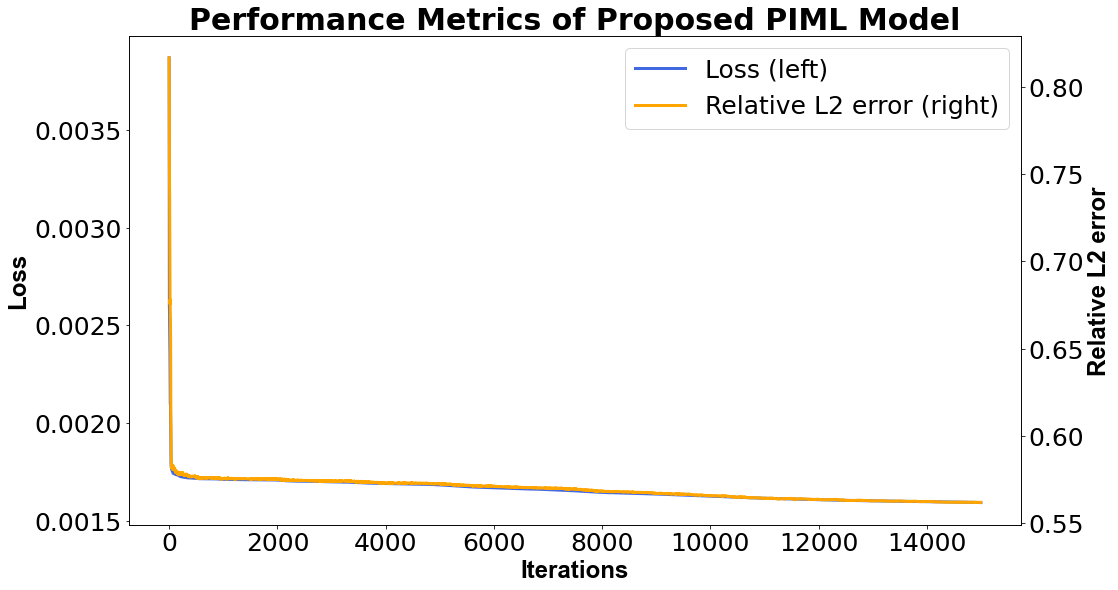

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.019495033330986195
MSE =  0.002738889711679287
RMSE =  0.05233440275458665
L2 relative error = 0.5113204491490385
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

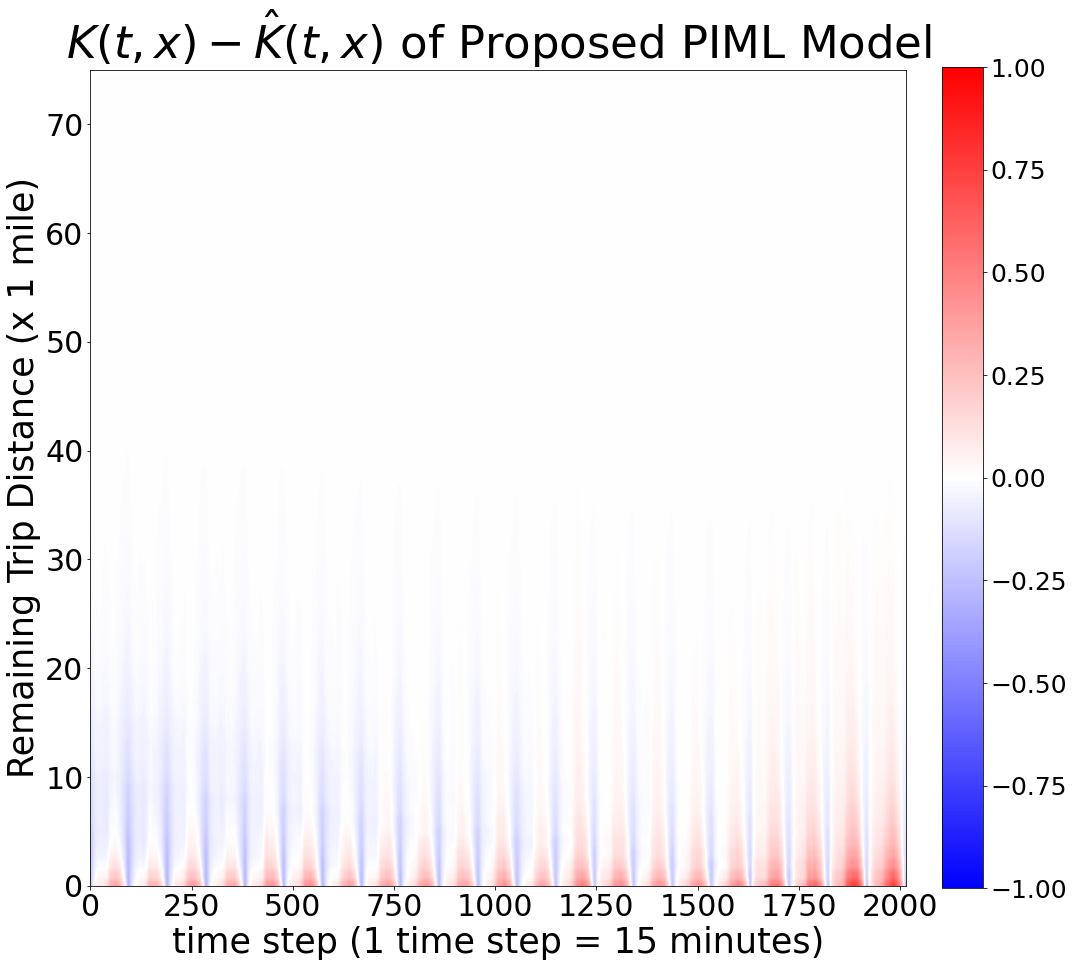

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

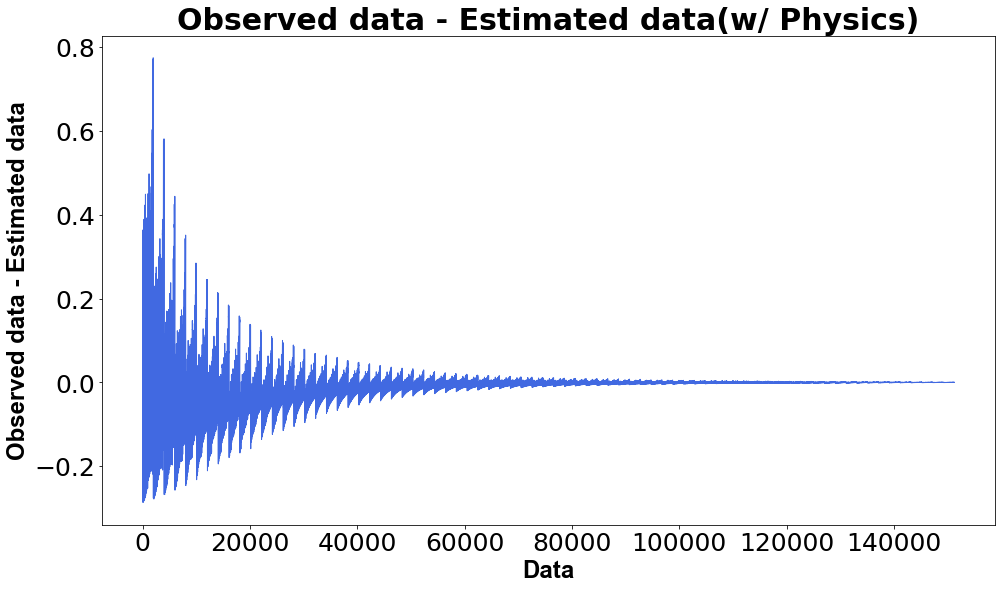

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

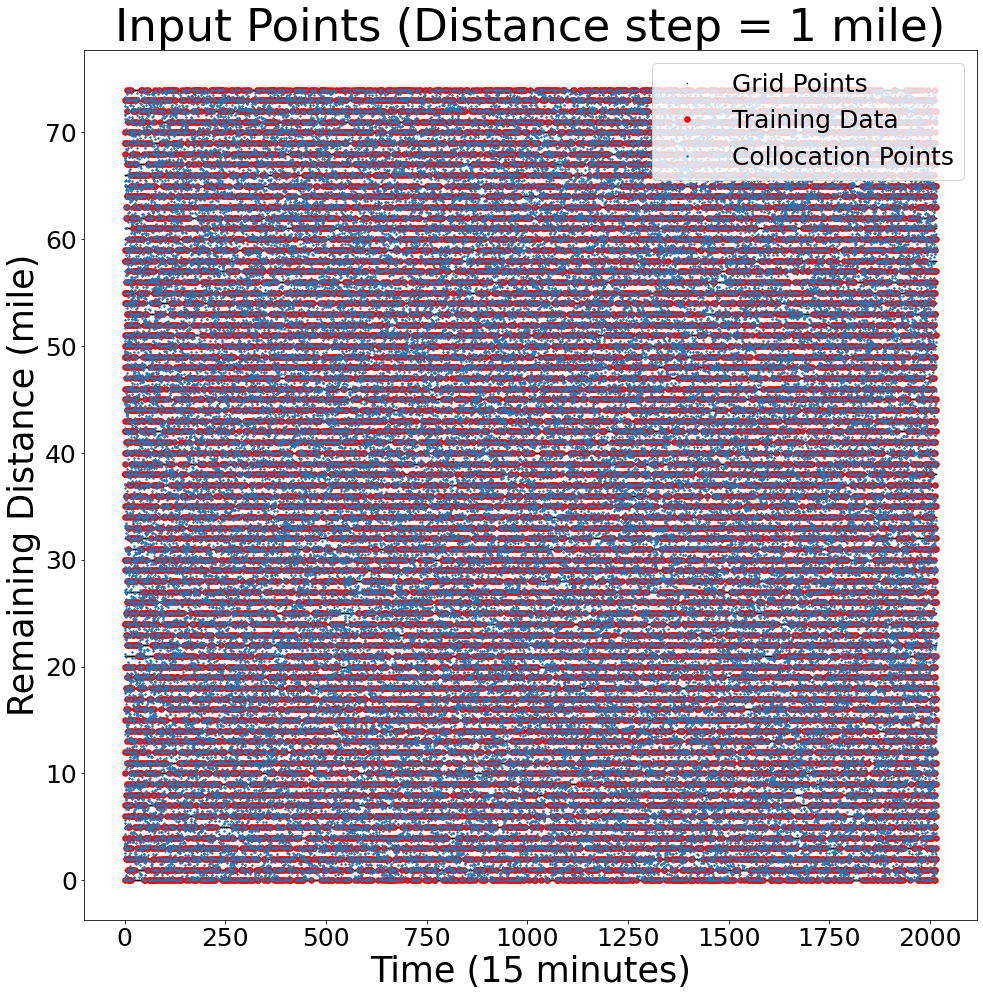

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

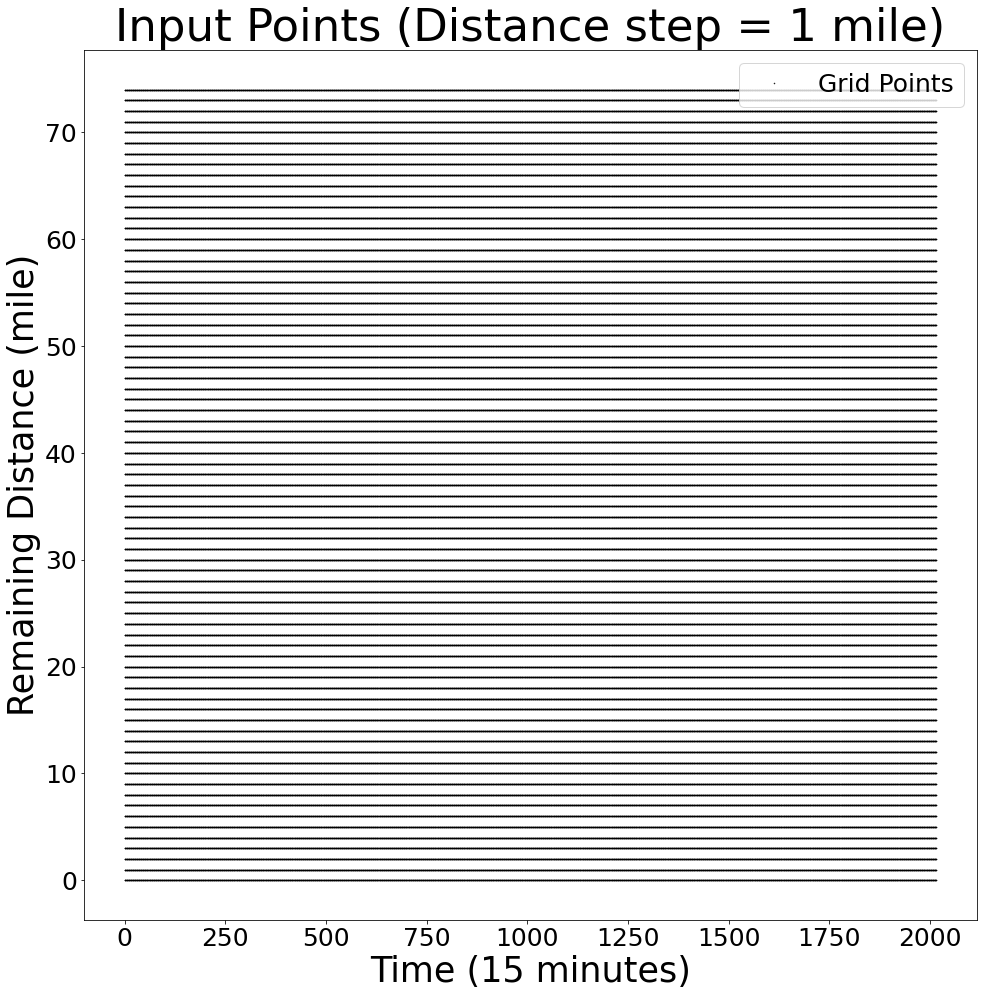

In [22]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

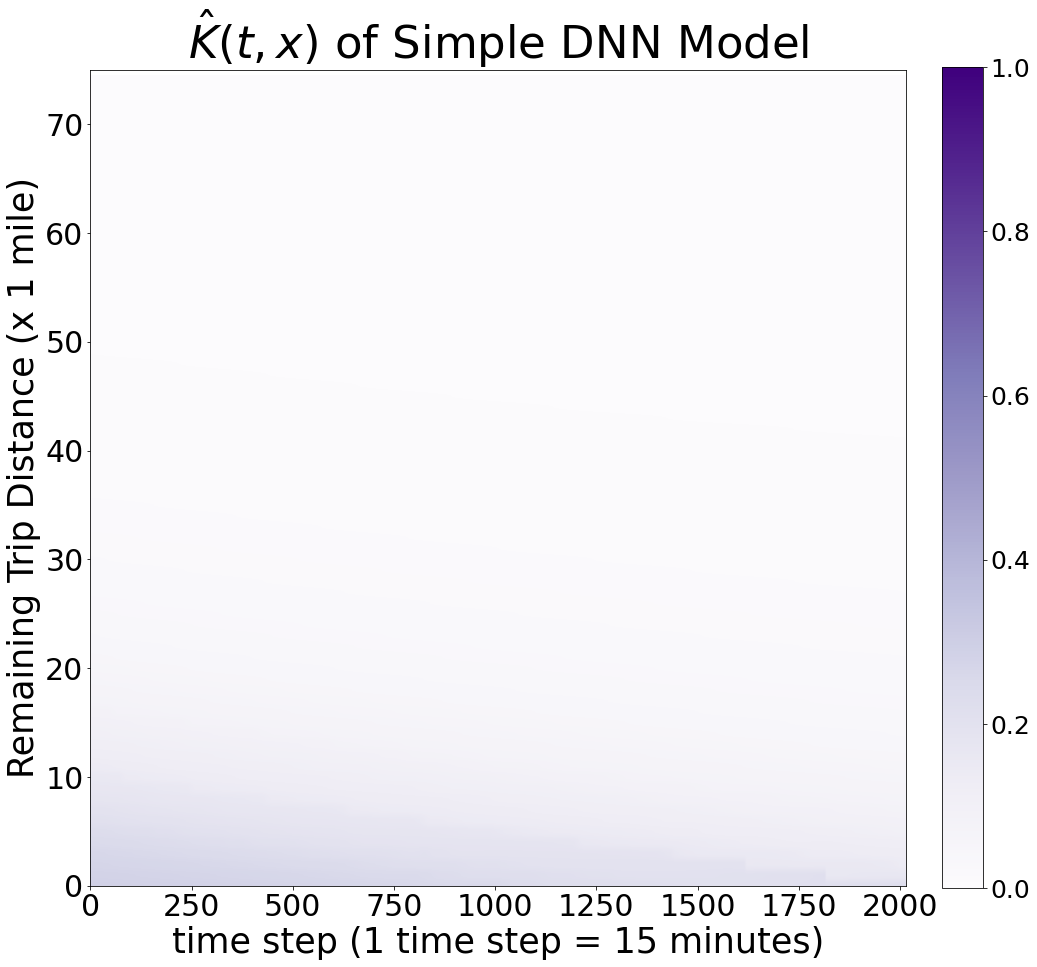

In [23]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

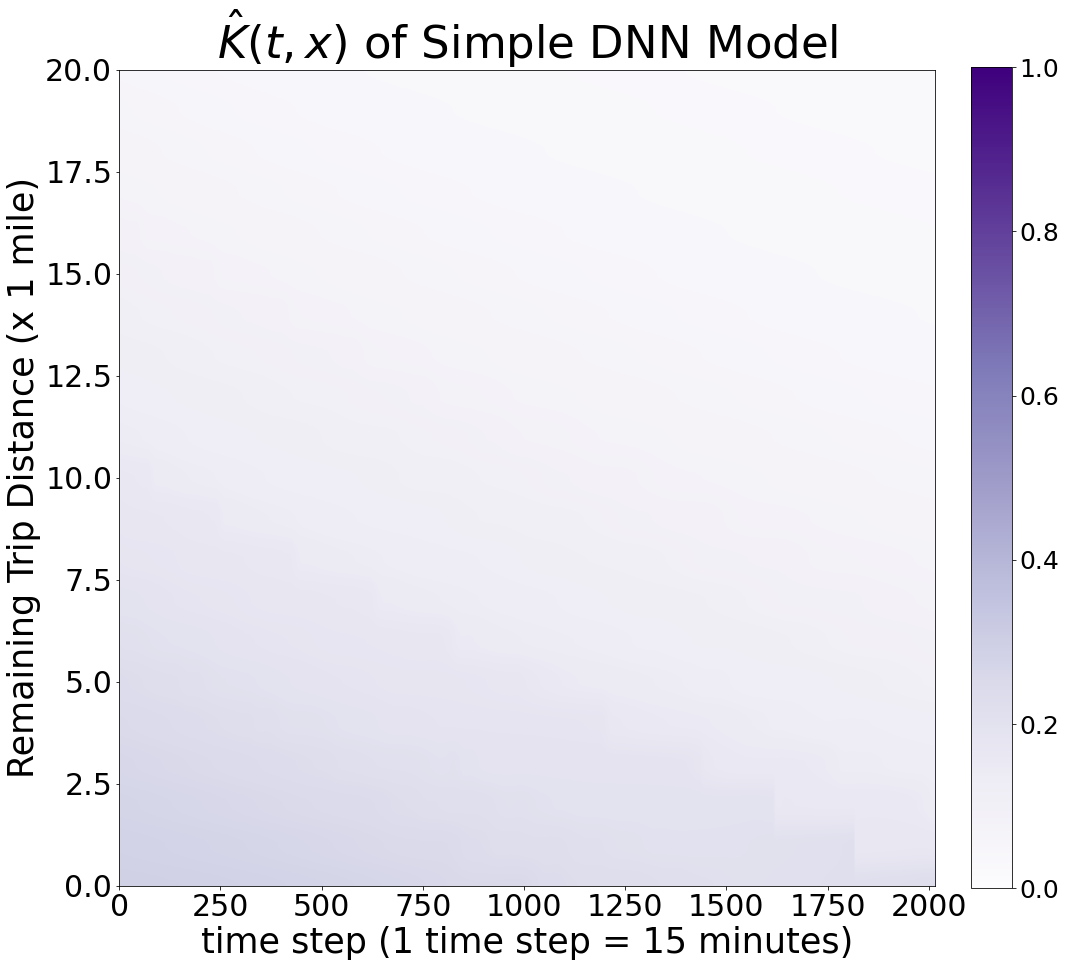

In [24]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

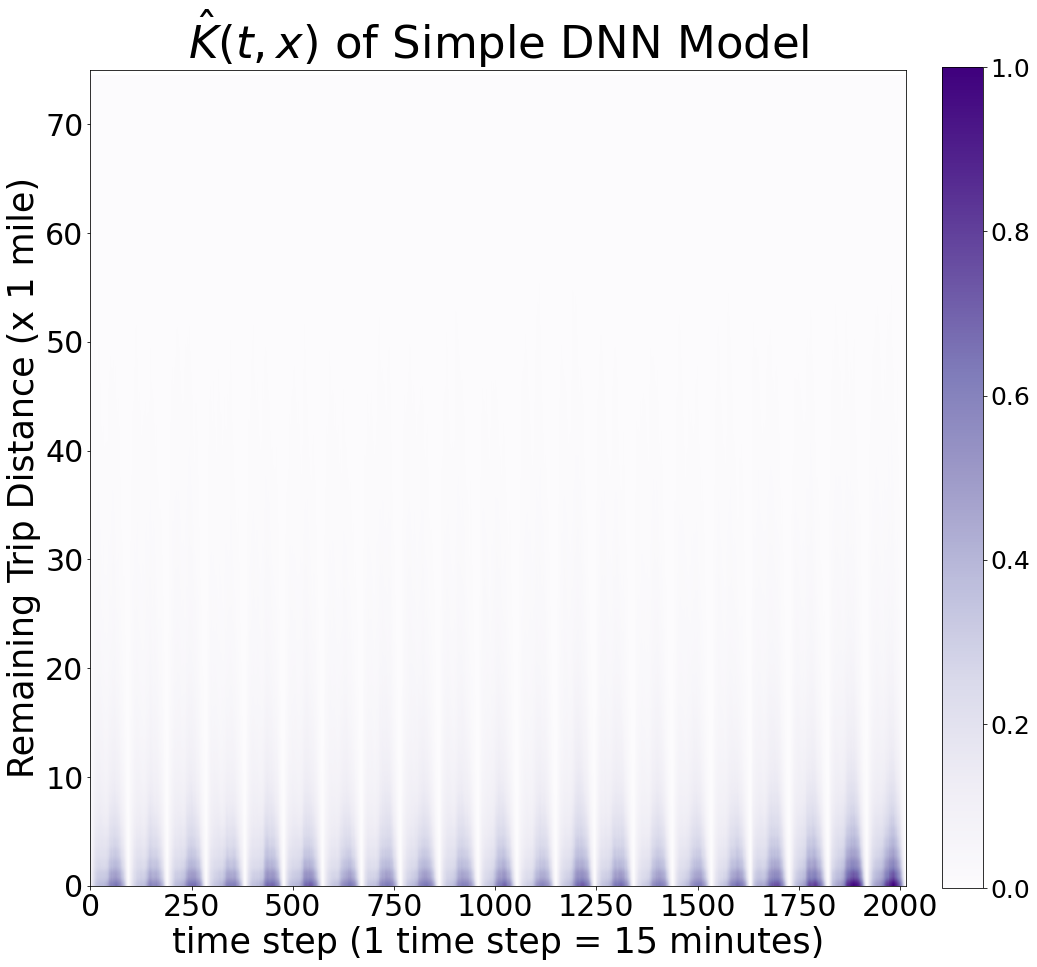

In [25]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

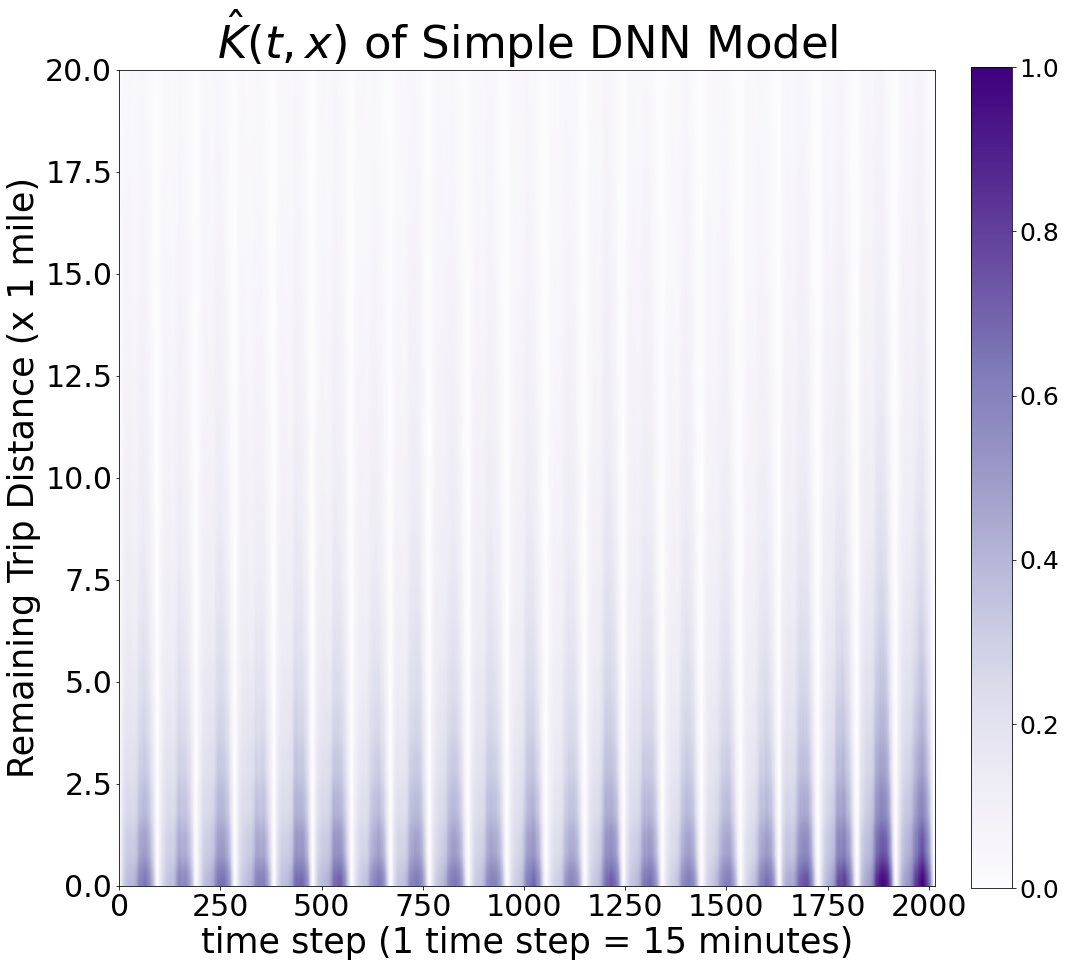

In [26]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)